In [229]:
%pip install filterpy tensorflow pykalman yfinance keras_tuner

from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
import os 

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\jhoe\appdata\local\programs\python\python312\lib\site-packages\backend-0.1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\jhoe\appdata\local\programs\python\python312\lib\site-packages\charset_normalizer-3.3.2-py3.12-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\jhoe\appdata\local\programs\python\python312\lib\site-packages\idna-3.6-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\us

In [230]:
# Macro variáveis para parâmetros
TICKER = '^GSPC'
START_DATE = "2020-01-01"  # Data inicial ajustada para 20 anos atrás
END_DATE = "2024-01-01"
LOOK_BACK = 21
DAYS_AHEAD = 3

SMA_WINDOW = 7
EMA_WINDOW = 7
RSI_WINDOW = 7

TEST_SIZE = 0.33
EPOCHS = 150 #150
BATCH_SIZE = 32 #32
PATIENCE = 10 #10
SHOW_DETAILS = 1


# Variáveis globais para ajuste de hiperparâmetros
MIN_LSTM_UNITS = 50
MAX_LSTM_UNITS = 400
STEP_LSTM_UNITS = 50
MIN_LEARNING_RATE = 1e-4
MAX_LEARNING_RATE = 1e-2
MAX_TRIALS = 1 #10  # Número máximo de experimentos durante a busca
EXECUTIONS_PER_TRIAL = 1 #5  # Quantas vezes executar o modelo para cada configuração

In [231]:
# Criar a pasta "graficos" se não existir
if not os.path.exists("graficos"):
    os.makedirs("graficos")

# Contador global para gráficos
plot_counter = 1

# Função para salvar gráficos
def save_plot(fig, title):
    global plot_counter
    # Substitui espaços e caracteres especiais por underscores, e adiciona extensão .png
    filename = f"graficos/{plot_counter}_{title.replace(' ', '_').replace(':', '').replace('/', '_')}_.png"
    fig.savefig(filename, format='png')  # Garante que o formato PNG seja usado
    plot_counter += 1

# Função para plotar dados de série temporal
def plot_data(data, columns, title, x_label='Data', y_label='Valor', labels=None, grid=True, figsize=(14, 7)):
    plt.figure(figsize=figsize)
    for i, column in enumerate(columns):
        label = labels[i] if labels else column
        plt.plot(data.index, data[column], label=label)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if labels:
        plt.legend()
    if grid:
        plt.grid(True)
    fig = plt.gcf()  # Captura a figura atual
    save_plot(fig, title)  # Salva a figura antes de exibir
    plt.show()
    plt.close(fig)  # Fecha a figura para evitar sobreposição

# Função para plotar histogramas
def plot_histogram(data, columns, title, x_label='Valor', y_label='Frequência', bins=50, labels=None, grid=True, figsize=(14, 7)):
    plt.figure(figsize=figsize)
    for i, column in enumerate(columns):
        label = labels[i] if labels else column
        sns.histplot(data[column], bins=bins, kde=True, edgecolor='black', alpha=0.5, label=label)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if labels:
        plt.legend()
    if grid:
        plt.grid(True)
    fig = plt.gcf()  # Captura a figura atual
    save_plot(fig, title)  # Salva a figura antes de exibir
    plt.show()
    plt.close(fig)  # Fecha a figura para evitar sobreposição

# Função para plotar os resultados
def plot_results(data, Y_test, predicted, title='Resultados do Modelo'):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index[-len(Y_test):], Y_test, color='blue', label='Dados Reais')
    plt.plot(data.index[-len(Y_test):], predicted, color='red', label='Dados Previstos')
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    fig = plt.gcf()  # Captura a figura atual
    plt.show()
    save_plot(fig, title)
    plt.close(fig)  # Fecha a figura para evitar sobreposição

# Função para plotar a perda de treinamento e validação
def plot_loss(model_title, history):
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Perda - Treinamento')
    plt.plot(history.history['val_loss'], label='Perda - Validação')
    plt.legend()
    plt.title(f'Perda de Treinamento e Validação - {model_title}')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    fig = plt.gcf()  # Captura a figura atual
    plt.show()
    save_plot(fig, f'Perda de Treinamento e Validação - {model_title}')
    plt.close(fig)  # Fecha a figura para evitar sobreposição

In [232]:
# Função para buscar dados históricos do S&P 500
def fetch_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)[['Close']].copy()

# Funções para cálculo dos indicadores técnicos
def SMA(data, window):
    return data.rolling(window=window).mean()

def EMA(data, window):
    return data.ewm(span=window, adjust=False).mean()

def RSI(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    rsi = rsi.fillna(50)  # Substituir NaN por 50
    rsi = rsi.replace(0, 50)  # Substituir 0 por 50
    return rsi

# Função para calcular Directional Accuracy (DA)
def directional_accuracy(predictions, actuals):
    # Convert predictions and actuals to numpy arrays
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate the directional accuracy
    return np.mean(np.sign(predictions[1:] - predictions[:-1]) == np.sign(actuals[1:] - actuals[:-1]))

# Função para criar datasets
def create_dataset(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Função para aplicar o filtro de Kalman
def kalman_filter(data):
    # Usar o primeiro valor dos dados como o estado inicial médio
    initial_state_mean = data.iloc[0]
    
    # Configurar uma covariância inicial adequada
    initial_state_covariance = 1.0
    
    # Criar o filtro de Kalman
    kf = KalmanFilter(
        initial_state_mean=initial_state_mean,
        initial_state_covariance=initial_state_covariance,
        n_dim_obs=1
    )
    
    # Aplicar o filtro de Kalman
    state_means, _ = kf.filter(data)
    
    return state_means

# Função para dividir dados em treinamento e teste
def split_data(X, Y, test_size=0.2):
    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y[:train_size], Y[train_size:]
    return X_train, X_test, Y_train, Y_test

# Função para treinar o modelo e prever
def train_and_predict_model(model_title, model, X_train, Y_train, X_test, Y_test):
    early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
    history = model.fit(X_train, Y_train, epochs=EPOCHS,
                                          batch_size=BATCH_SIZE,
                                          validation_data=(X_test, Y_test),
                                          callbacks=[early_stopping],
                                          verbose=SHOW_DETAILS)
    plot_loss(model_title, history)
    return model.predict(X_test)

# Função para avaliar o modelo
def evaluate_model(val_predict, y_val_actual, title='Avaliação do Modelo'):
    rmse = np.sqrt(mean_squared_error(y_val_actual, val_predict))
    mae = mean_absolute_error(y_val_actual, val_predict)
    mse = mean_squared_error(y_val_actual, val_predict)
    r2 = r2_score(y_val_actual, val_predict)
    da = directional_accuracy(val_predict, y_val_actual)

    # Criação do DataFrame para armazenar os resultados
    results = pd.DataFrame({
        'Métrica': ['RMSE', 'MAE', 'MSE', 'R²', 'DA'],
        'Valor': [rmse, mae, mse, r2, da]
    })

    # Plotando a tabela
    fig, ax = plt.subplots(figsize=(3.3, 1.6))  # Ajuste do tamanho da figura para remover espaços
    ax.axis('off')

    # Criando a tabela com um layout mais ajustado
    table = ax.table(cellText=results.values, colLabels=results.columns, cellLoc='center', loc='center')

    # Ajustando o layout da tabela
    table.scale(1.5, 1.5)  # Ajuste da escala para melhor visualização
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.auto_set_column_width(col=list(range(len(results.columns))))

    save_plot(fig, title)  # Salvar a tabela como imagem
    plt.show()
    plt.close(fig)  # Fechar a figura para liberar a memória

    return rmse, mae, mse, r2, da

[*********************100%***********************]  1 of 1 completed


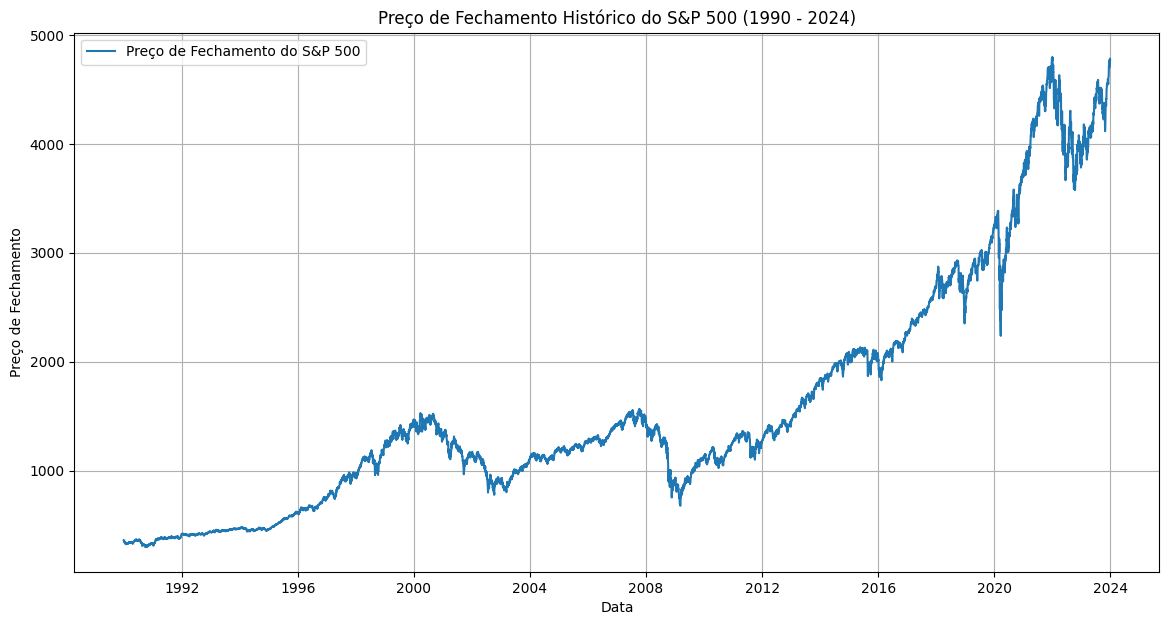

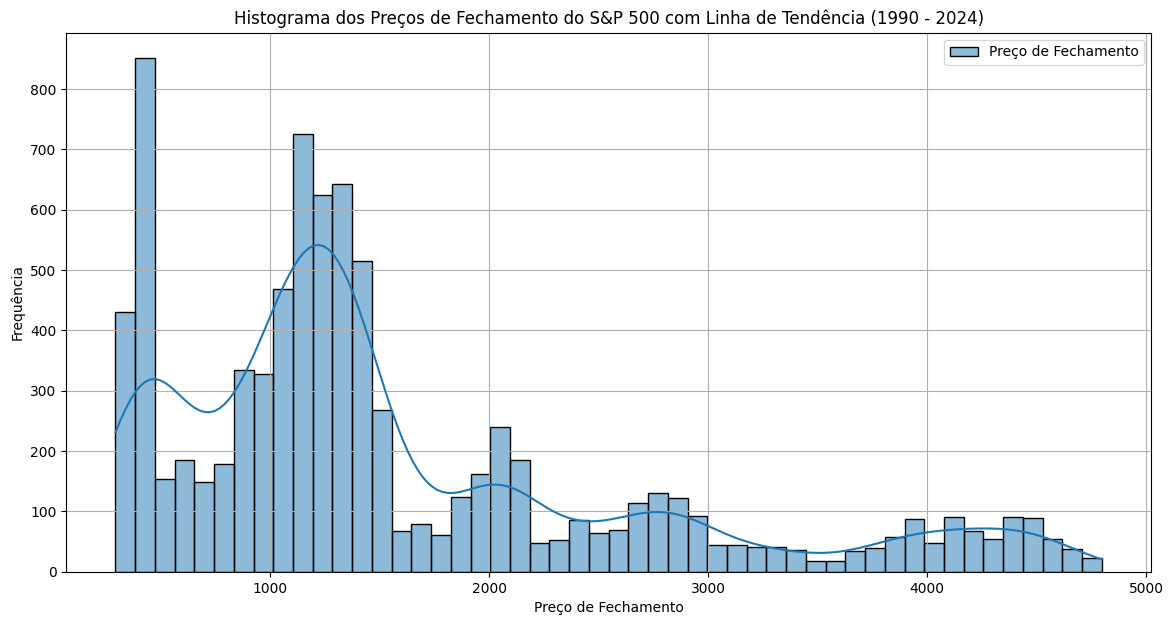

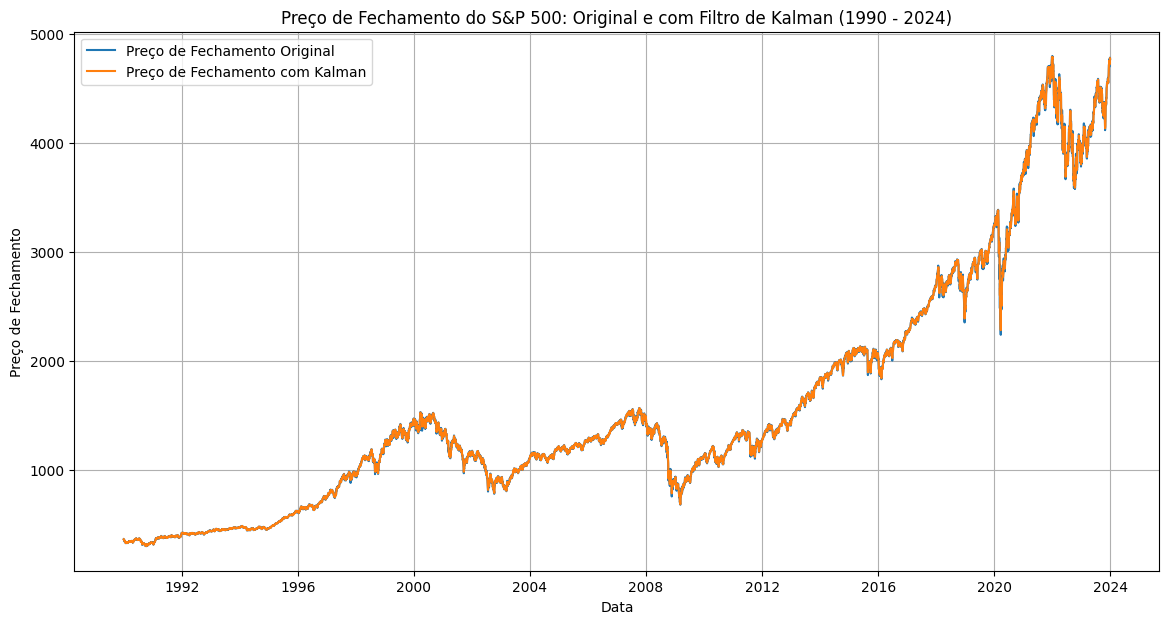

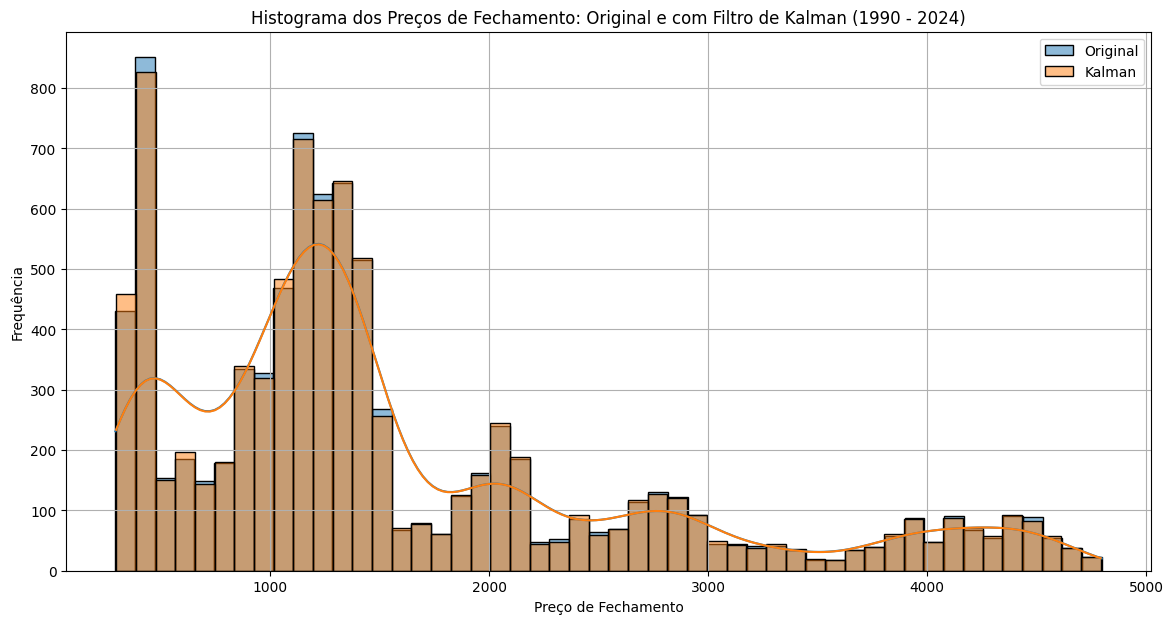

In [233]:
# Buscando os dados
dados = fetch_data(ticker='^GSPC', start_date='1990-01-01', end_date='2024-01-01')

# Plotando os dados de fechamento
plot_data(
    data=dados, 
    columns=['Close'], 
    title='Preço de Fechamento Histórico do S&P 500 (1990 - 2024)', 
    x_label='Data', 
    y_label='Preço de Fechamento',
    labels=['Preço de Fechamento do S&P 500']
)

# Plotando o histograma dos preços de fechamento com a linha de tendência
plot_histogram(
    data=dados, 
    columns=['Close'], 
    title='Histograma dos Preços de Fechamento do S&P 500 com Linha de Tendência (1990 - 2024)',
    x_label='Preço de Fechamento', 
    y_label='Frequência',
    labels=['Preço de Fechamento']
)

# Aplicando o filtro de Kalman nos preços de fechamento
kalman_resultado = kalman_filter(dados['Close'])

# Transformando o resultado do filtro de Kalman em um DataFrame
kalman_resultado = pd.DataFrame(kalman_resultado, index=dados.index, columns=['Close_Kalman'])

# Combinar dados para plotagem
dados_combinados = pd.concat([dados[['Close']], kalman_resultado], axis=1)

# Plotando os dados de fechamento originais e com Kalman
plot_data(
    data=dados_combinados,
    columns=['Close', 'Close_Kalman'],
    title='Preço de Fechamento do S&P 500: Original e com Filtro de Kalman (1990 - 2024)',
    x_label='Data',
    y_label='Preço de Fechamento',
    labels=['Preço de Fechamento Original', 'Preço de Fechamento com Kalman']
)

# Plotando o histograma dos preços de fechamento com e sem filtro de Kalman
plot_histogram(
    data=dados_combinados,
    columns=['Close', 'Close_Kalman'],
    title='Histograma dos Preços de Fechamento: Original e com Filtro de Kalman (1990 - 2024)',
    x_label='Preço de Fechamento',
    y_label='Frequência',
    labels=['Original', 'Kalman']
)

[*********************100%***********************]  1 of 1 completed

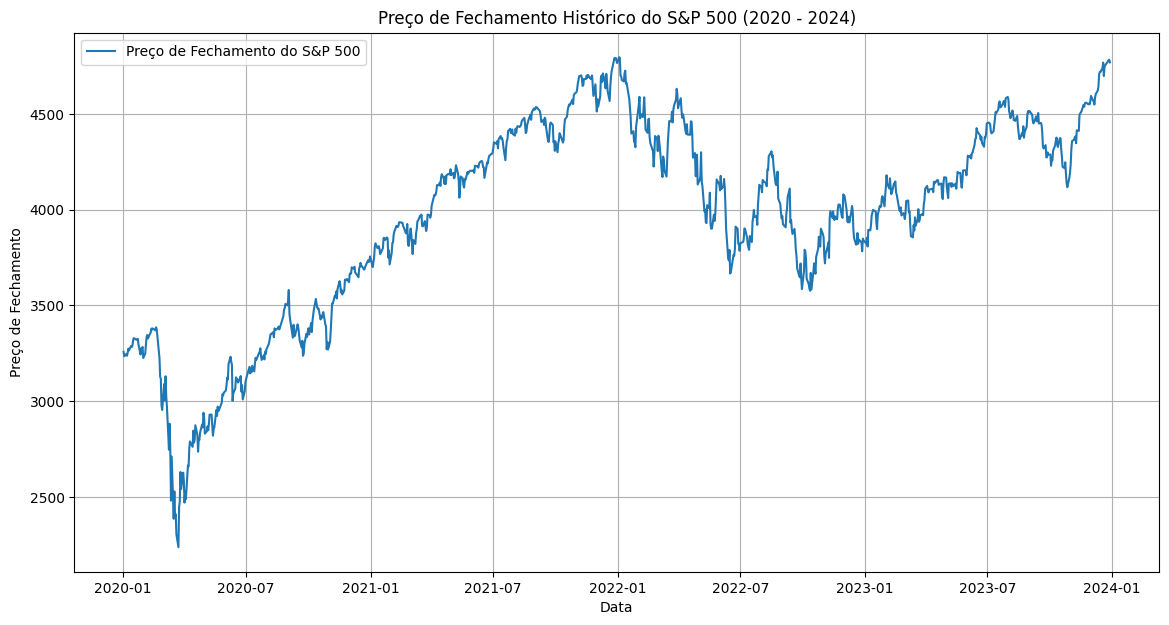

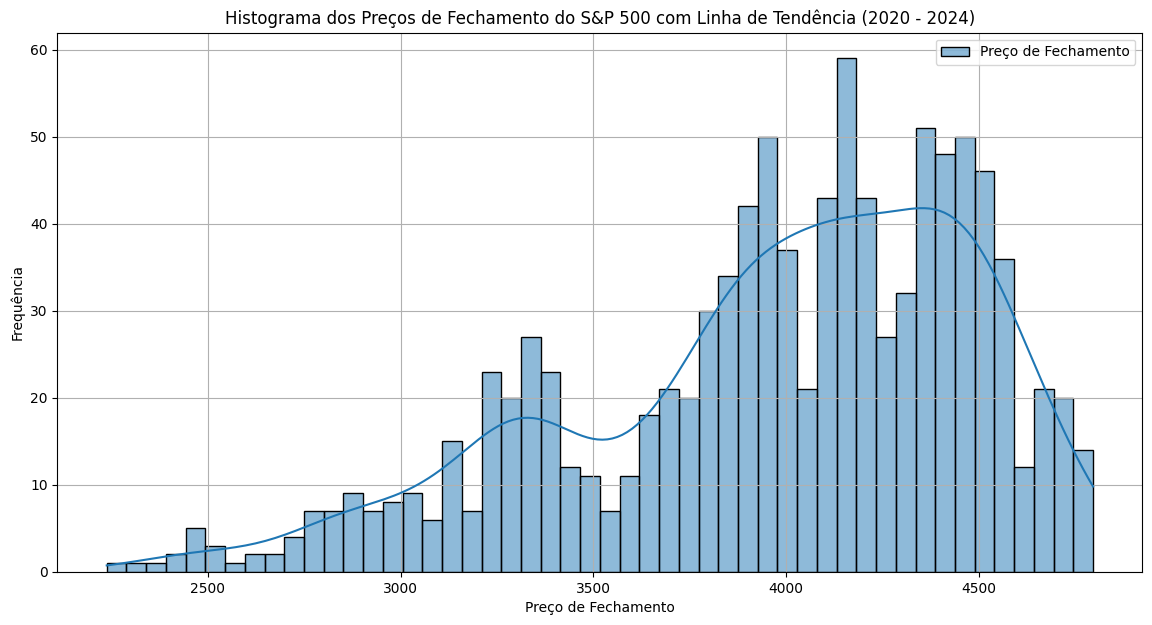

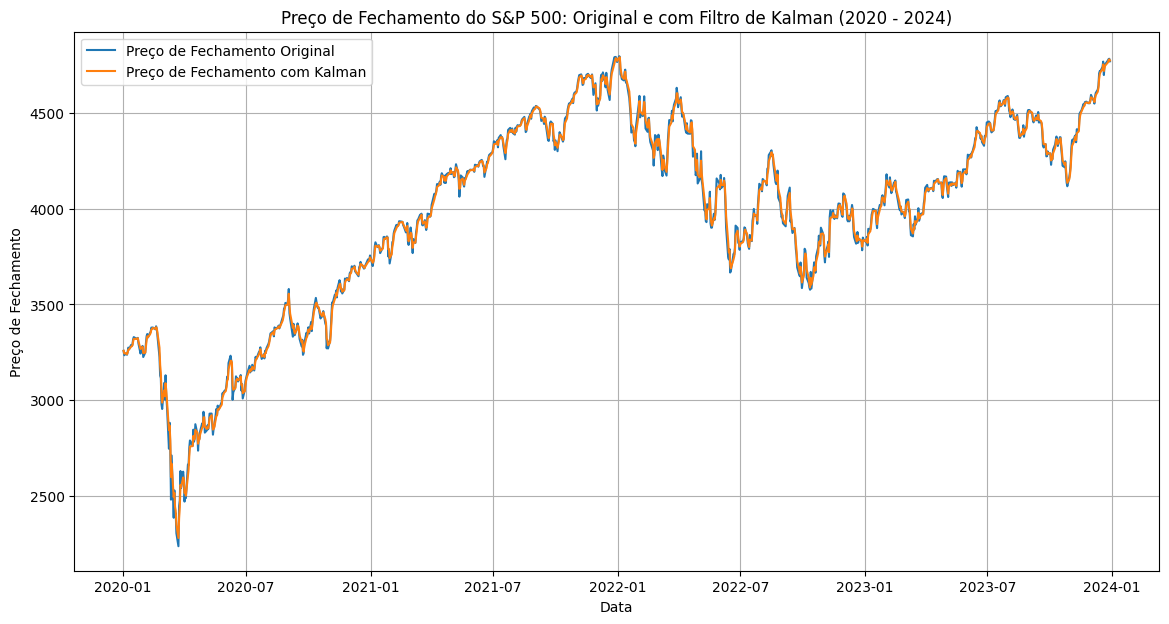

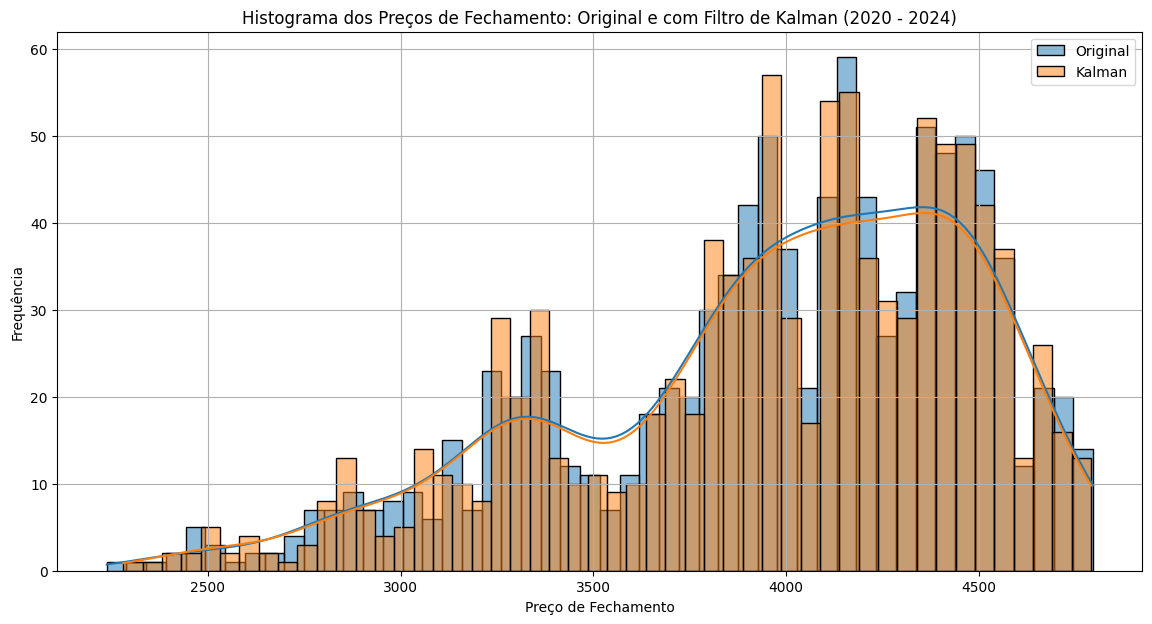

In [234]:
# Buscando os dados
dados = fetch_data(ticker=TICKER, start_date=START_DATE, end_date=END_DATE)

# Plotando os dados de fechamento
plot_data(
    data=dados, 
    columns=['Close'], 
    title='Preço de Fechamento Histórico do S&P 500 (2020 - 2024)', 
    x_label='Data', 
    y_label='Preço de Fechamento',
    labels=['Preço de Fechamento do S&P 500']
)

# Plotando o histograma dos preços de fechamento com a linha de tendência
plot_histogram(
    data=dados, 
    columns=['Close'], 
    title='Histograma dos Preços de Fechamento do S&P 500 com Linha de Tendência (2020 - 2024)',
    x_label='Preço de Fechamento', 
    y_label='Frequência',
    labels=['Preço de Fechamento']
)

# Aplicando o filtro de Kalman nos preços de fechamento
kalman_resultado = kalman_filter(dados['Close'])

# Transformando o resultado do filtro de Kalman em um DataFrame
kalman_resultado = pd.DataFrame(kalman_resultado, index=dados.index, columns=['Close_Kalman'])

# Combinar dados para plotagem
dados_combinados = pd.concat([dados[['Close']], kalman_resultado], axis=1)

# Plotando os dados de fechamento originais e com Kalman
plot_data(
    data=dados_combinados,
    columns=['Close', 'Close_Kalman'],
    title='Preço de Fechamento do S&P 500: Original e com Filtro de Kalman (2020 - 2024)',
    x_label='Data',
    y_label='Preço de Fechamento',
    labels=['Preço de Fechamento Original', 'Preço de Fechamento com Kalman']
)

# Plotando o histograma dos preços de fechamento com e sem filtro de Kalman
plot_histogram(
    data=dados_combinados,
    columns=['Close', 'Close_Kalman'],
    title='Histograma dos Preços de Fechamento: Original e com Filtro de Kalman (2020 - 2024)',
    x_label='Preço de Fechamento',
    y_label='Frequência',
    labels=['Original', 'Kalman']
)

In [235]:
# Criação dos modelos ajustados com hiperparâmetros dinâmicos usando Keras Tuner
def create_lstm_model(hp, input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Unidades LSTM como hiperparâmetros ajustáveis
    units_1 = hp.Int('units_1', min_value=MIN_LSTM_UNITS, max_value=MAX_LSTM_UNITS, step=STEP_LSTM_UNITS)
    model.add(LSTM(units_1, return_sequences=True))

    units_2 = hp.Int('units_2', min_value=MIN_LSTM_UNITS, max_value=MAX_LSTM_UNITS, step=STEP_LSTM_UNITS)
    model.add(LSTM(units_2))

    model.add(Dense(1))

    # Taxa de aprendizado ajustável
    learning_rate = hp.Float('learning_rate', min_value=MIN_LEARNING_RATE, max_value=MAX_LEARNING_RATE, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model

In [236]:
# Criação dos modelos ajustados com hiperparâmetros dinâmicos usando Keras Tuner
def create_bilstm_model(hp, input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Unidades LSTM como hiperparâmetros ajustáveis
    units_1 = hp.Int('units_1', min_value=MIN_LSTM_UNITS, max_value=MAX_LSTM_UNITS, step=STEP_LSTM_UNITS)
    model.add(Bidirectional(LSTM(units_1, return_sequences=True)))

    units_2 = hp.Int('units_2', min_value=MIN_LSTM_UNITS, max_value=MAX_LSTM_UNITS, step=STEP_LSTM_UNITS)
    model.add(Bidirectional(LSTM(units_2)))

    model.add(Dense(1))

    # Taxa de aprendizado ajustável
    learning_rate = hp.Float('learning_rate', min_value=MIN_LEARNING_RATE, max_value=MAX_LEARNING_RATE, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model

In [237]:
# Criação dos modelos ajustados com hiperparâmetros dinâmicos usando Keras Tuner
def create_stacked_lstm_model(hp, input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Unidades LSTM como hiperparâmetros ajustáveis
    units_1 = hp.Int('units_1', min_value=MIN_LSTM_UNITS, max_value=MAX_LSTM_UNITS, step=STEP_LSTM_UNITS)
    model.add(LSTM(units_1, return_sequences=True))

    units_2 = hp.Int('units_2', min_value=MIN_LSTM_UNITS, max_value=MAX_LSTM_UNITS, step=STEP_LSTM_UNITS)
    model.add(LSTM(units_2, return_sequences=True))

    units_3 = hp.Int('units_3', min_value=MIN_LSTM_UNITS, max_value=MAX_LSTM_UNITS, step=STEP_LSTM_UNITS)
    model.add(LSTM(units_3))

    model.add(Dense(1))

    # Taxa de aprendizado ajustável
    learning_rate = hp.Float('learning_rate', min_value=MIN_LEARNING_RATE, max_value=MAX_LEARNING_RATE, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model

In [238]:
# Função de criação de modelo generalizada
def create_model(hp, model_fn, input_shape):
    return model_fn(hp, input_shape)

In [239]:
# Função para criar o tuner generalizado
def create_new_tuner(model_fn, input_shape, project_name):
    tuner = kt.RandomSearch(
        lambda hp: create_model(hp, model_fn, input_shape),
        objective='val_loss',
        max_trials=MAX_TRIALS,
        executions_per_trial=EXECUTIONS_PER_TRIAL,
        directory=f'my_dir_{project_name}',
        project_name=project_name
    )
    return tuner

In [240]:
# Buscando os dados
data = fetch_data(ticker=TICKER, start_date=START_DATE, end_date=END_DATE)

# Preparação dos dados para diferentes modelos
scaler_close_only = MinMaxScaler(feature_range=(0, 1))
scaled_data_close_only = scaler_close_only.fit_transform(data)
X_basic, Y_basic = create_dataset(scaled_data_close_only, LOOK_BACK)
X_basic = np.reshape(X_basic, (X_basic.shape[0], X_basic.shape[1], 1))

# print(f"Shape of X_basic: {X_basic.shape}")
# print(f"Shape of Y_basic: {Y_basic.shape}")
# print(f"First 5 rows of X_basic: {X_basic[:5]}")
# print(f"First 5 rows of Y_basic: {Y_basic[:5]}")

# Dividindo os dados em treinamento e teste
X_train_basic, X_test_basic, Y_train_basic, Y_test_basic = split_data(X_basic, Y_basic, test_size=TEST_SIZE)
# Inversão da escala para obter os valores originais de treinamento e validação
y_val_actual = scaler_close_only.inverse_transform(Y_test_basic.reshape(-1, 1))
# print(f"Shape of y_val_actual: {y_val_actual.shape}")
# print(f"First 5 rows of y_val_actual: {y_val_actual[:5]}")

# Cria parametros do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

# Definindo a forma de entrada
input_shape_1 = (LOOK_BACK, 1)

# Executando a busca de hiperparâmetros
tuner_lstm = create_new_tuner(create_lstm_model, input_shape_1, project_name='lstm_tuning')
tuner_lstm.search(X_train_basic, Y_train_basic, epochs=EPOCHS, validation_data=(X_test_basic, Y_test_basic), callbacks=[early_stopping], verbose=SHOW_DETAILS)

# Obtendo o melhor modelo
best_model_lstm_basic = tuner_lstm.get_best_models(num_models=1)[0]

# Treinamento e previsões para o modelo LSTM ajustado
predicted_basic = train_and_predict_model('LSTM (Apenas Preço)', best_model_lstm_basic, X_train_basic, Y_train_basic, X_test_basic, Y_test_basic)

# Inversão da escala valores de previsão
predicted_basic = scaler_close_only.inverse_transform(predicted_basic)

# Função para avaliar o modelo
evaluate_model(predicted_basic, y_val_actual, 'LSTM (Apenas Preço)')


# Executando a busca de hiperparâmetros
tuner_bilstm = create_new_tuner(create_bilstm_model, input_shape_1, project_name='bilstm_tuning')
tuner_bilstm.search(X_train_basic, Y_train_basic, epochs=EPOCHS, validation_data=(X_test_basic, Y_test_basic), callbacks=[early_stopping], verbose=SHOW_DETAILS)

# Obtendo o melhor modelo
best_model_bilstm_basic = tuner_bilstm.get_best_models(num_models=1)[0]

predicted_bi_close = train_and_predict_model('Bi-LSTM (Apenas Preço)', best_model_bilstm_basic, X_train_basic, Y_train_basic, X_test_basic, Y_test_basic)

# Inversão da escala valores de previsão
predicted_bi_close = scaler_close_only.inverse_transform(predicted_bi_close)

# Função para avaliar o modelo
evaluate_model(predicted_bi_close, y_val_actual, 'Bi-LSTM (Apenas Preço)')



# Executando a busca de hiperparâmetros
tuner_stacked_lstm = create_new_tuner(create_stacked_lstm_model, input_shape_1, project_name='stacked_lstm_tuning')
tuner_stacked_lstm.search(X_train_basic, Y_train_basic, epochs=EPOCHS, validation_data=(X_test_basic, Y_test_basic), callbacks=[early_stopping], verbose=SHOW_DETAILS)

# Obtendo o melhor modelo
best_model_stacked_basic = tuner_stacked_lstm.get_best_models(num_models=1)[0]

predicted_stacked_close = train_and_predict_model('Stacked LSTM (Apenas Preço)', best_model_stacked_basic, X_train_basic, Y_train_basic, X_test_basic, Y_test_basic)

# Inversão da escala valores de previsão
predicted_stacked_close = scaler_close_only.inverse_transform(predicted_stacked_close)

# Função para avaliar o modelo
evaluate_model(predicted_stacked_close, y_val_actual, 'Stacked LSTM (Apenas Preço)')

[*********************100%***********************]  1 of 1 completed


Reloading Tuner from my_dir_lstm_tuning\lstm_tuning\tuner0.json


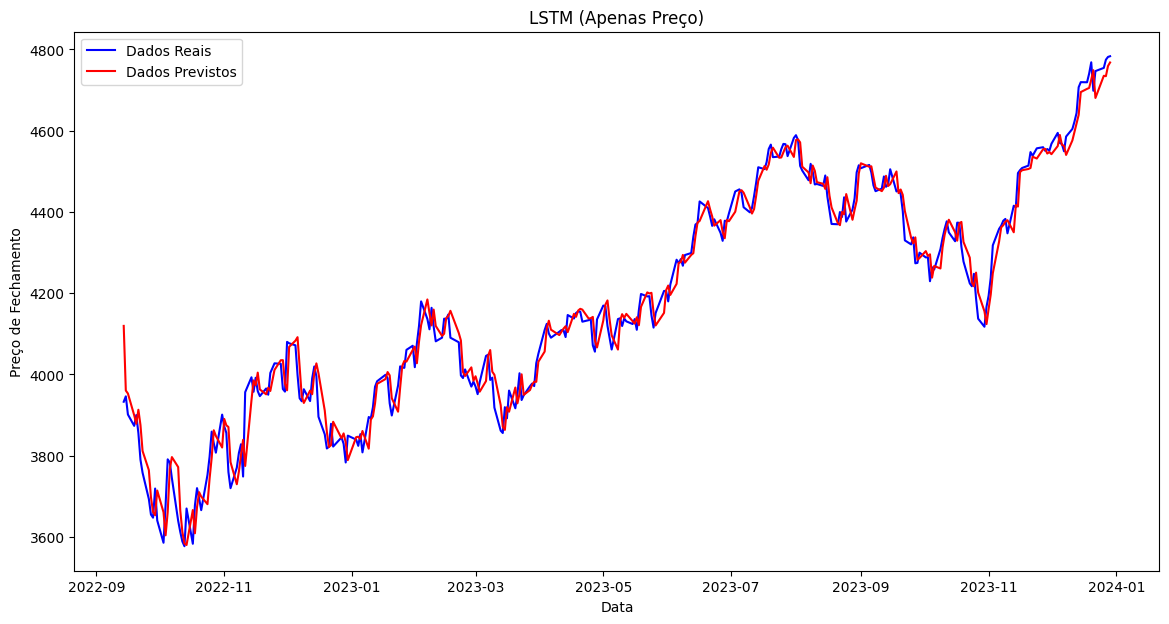

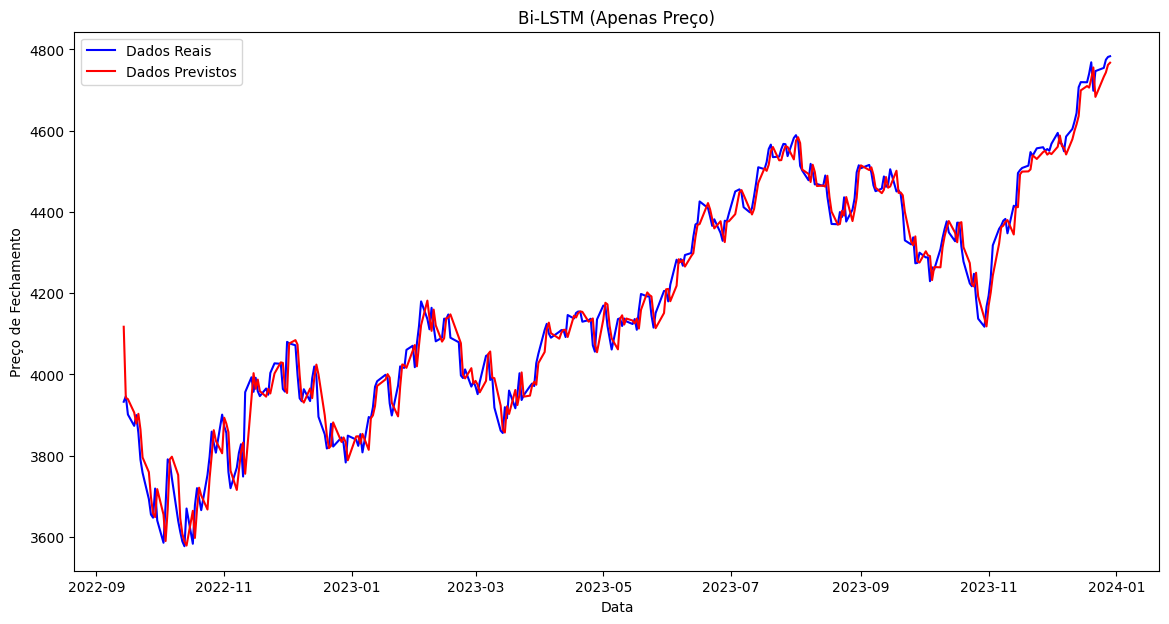

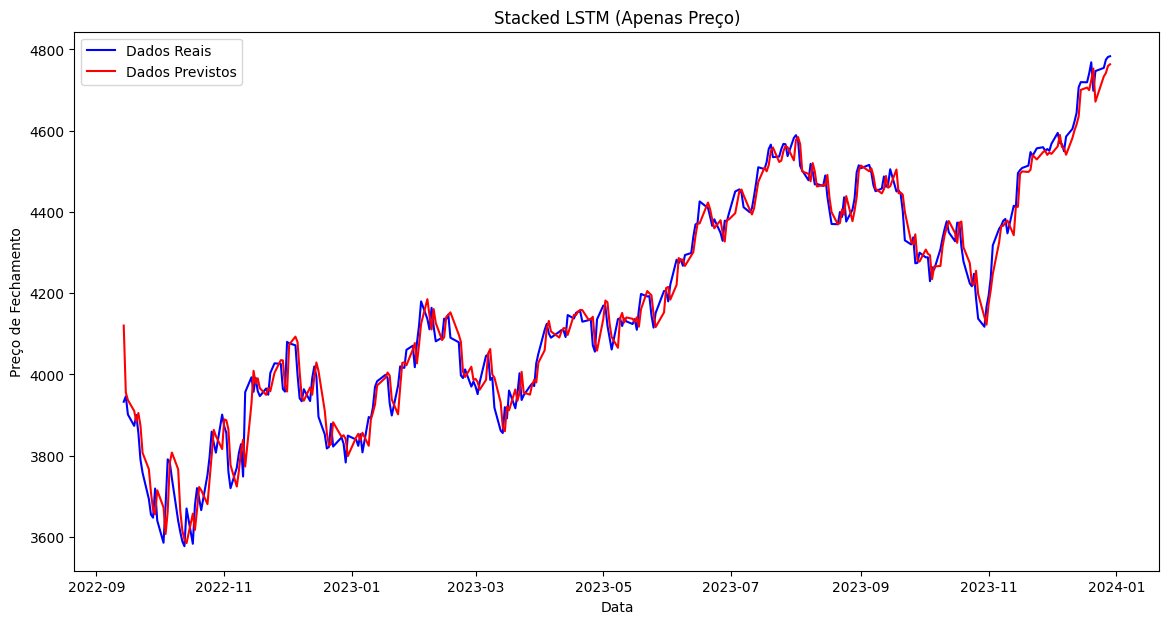

In [ ]:
# Plotando os resultados para LSTM Básico
plot_results(data, y_val_actual, predicted_basic, title='LSTM (Apenas Preço)')

# Plotando os resultados para Bi-LSTM
plot_results(data, y_val_actual, predicted_bi_close, title='Bi-LSTM (Apenas Preço)')

# Plotando os resultados para Stacked LSTM
plot_results(data, y_val_actual, predicted_stacked_close, title='Stacked LSTM (Apenas Preço)')

Trial 10 Complete [01h 15m 20s]
val_loss: 0.00029997210076544435

Best val_loss So Far: 9.296406278735958e-05
Total elapsed time: 2d 09h 07m 31s
Epoch 1/150


c:\Users\Jhoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - loss: 0.0156 - val_loss: 0.0014
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - loss: 9.5541e-04 - val_loss: 7.2655e-04
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - loss: 5.1454e-04 - val_loss: 2.0259e-04
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - loss: 3.3302e-04 - val_loss: 2.1081e-04
Epoch 5/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step - loss: 2.4140e-04 - val_loss: 1.3844e-04
Epoch 6/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - loss: 2.4050e-04 - val_loss: 1.2742e-04
Epoch 7/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - loss: 1.8267e-04 - val_loss: 1.2293e-04
Epoch 8/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - loss: 2.2152e-04 - val_loss: 1.2370e-04
Epoch 9/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - loss: 1.7969e-04 - val_loss: 1.9376e-04
Epoch 10/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - loss: 2.0057e-04 - val_loss: 3.1844e-04
Epoch 11/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - loss: 2.4952

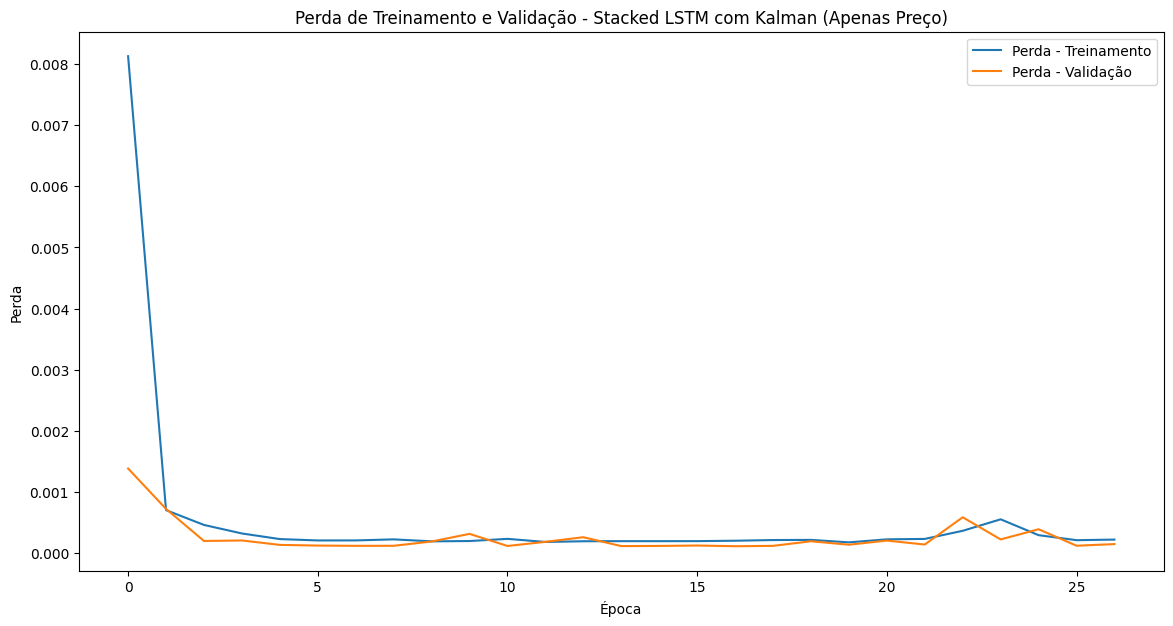

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step


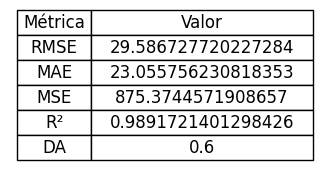

(29.586727720227284,
 23.055756230818353,
 875.3744571908657,
 0.9891721401298426,
 0.6)

In [ ]:
# Buscando os dados
data = fetch_data(ticker=TICKER, start_date=START_DATE, end_date=END_DATE)

# Preparação dos dados para diferentes modelos com Kalman
scaler_kalman_close_only = MinMaxScaler(feature_range=(0, 1))

# Aplicando o filtro de Kalman nos dados sem indicadores técnicos
scaled_kalman_data_close_only = scaler_kalman_close_only.fit_transform(kalman_filter(data))

X_kalman_basic, Y_kalman_basic = create_dataset(scaled_kalman_data_close_only, LOOK_BACK)
X_kalman_basic = np.reshape(X_kalman_basic, (X_kalman_basic.shape[0], X_kalman_basic.shape[1], 1))

# Dividindo os dados em treinamento e teste
X_train_kalman_basic, X_test_kalman_basic, Y_train_kalman_basic, Y_test_kalman_basic = split_data(X_kalman_basic, Y_kalman_basic, test_size=TEST_SIZE)

# Inversão da escala para obter os valores originais de treinamento e validação
y_kalman_val_actual = scaler_close_only.inverse_transform(Y_test_kalman_basic.reshape(-1, 1))


# Executando a busca de hiperparâmetros
tuner_lstm = create_new_tuner(create_lstm_model, input_shape_1, project_name='kalman_lstm_tuning')
tuner_lstm.search(X_train_kalman_basic, Y_train_kalman_basic, epochs=EPOCHS, validation_data=(X_test_kalman_basic, Y_test_kalman_basic), callbacks=[early_stopping], verbose=SHOW_DETAILS)

# Obtendo o melhor modelo
best_model_lstm_kalman = tuner_lstm.get_best_models(num_models=1)[0]

predicted_kalman_basic = train_and_predict_model('LSTM com Kalman (Apenas Preço)', best_model_lstm_kalman, X_train_kalman_basic, Y_train_kalman_basic, X_test_kalman_basic, Y_test_kalman_basic)

# Inversão da escala para obter os valores originais de treinamento e validação
predicted_kalman_basic = scaler_kalman_close_only.inverse_transform(predicted_kalman_basic)

# Função para avaliar o modelo
evaluate_model(predicted_kalman_basic, y_kalman_val_actual, 'LSTM com Kalman (Apenas Preço)')



# Executando a busca de hiperparâmetros
tuner_bilstm = create_new_tuner(create_bilstm_model, input_shape_1, project_name='kalman_bilstm_tuning')
tuner_bilstm.search(X_train_kalman_basic, Y_train_kalman_basic, epochs=EPOCHS, validation_data=(X_test_kalman_basic, Y_test_kalman_basic), callbacks=[early_stopping], verbose=SHOW_DETAILS)

# Obtendo o melhor modelo
best_model_bilstm_kalman = tuner_bilstm.get_best_models(num_models=1)[0]

predicted_kalman_bi_close = train_and_predict_model('Bi-LSTM com Kalman (Apenas Preço)', best_model_bilstm_kalman, X_train_kalman_basic, Y_train_kalman_basic, X_test_kalman_basic, Y_test_kalman_basic)

# Inversão da escala para obter os valores originais de treinamento e validação
predicted_kalman_bi_close = scaler_kalman_close_only.inverse_transform(predicted_kalman_bi_close)

# Função para avaliar o modelo
evaluate_model(predicted_kalman_bi_close, y_kalman_val_actual, 'Bi-LSTM com Kalman (Apenas Preço)')



# Executando a busca de hiperparâmetros
tuner_stacked = create_new_tuner(create_stacked_lstm_model, input_shape_1, project_name='kalman_stacked_lstm_tuning')
tuner_stacked.search(X_train_kalman_basic, Y_train_kalman_basic, epochs=EPOCHS, validation_data=(X_test_kalman_basic, Y_test_kalman_basic), callbacks=[early_stopping], verbose=SHOW_DETAILS)

# Obtendo o melhor modelo
best_model_stacked_kalman = tuner_stacked.get_best_models(num_models=1)[0]

predicted_kalman_stacked_close = train_and_predict_model('Stacked LSTM com Kalman (Apenas Preço)', best_model_stacked_kalman, X_train_kalman_basic, Y_train_kalman_basic, X_test_kalman_basic, Y_test_kalman_basic)

# Inversão da escala para obter os valores originais de treinamento e validação
predicted_kalman_stacked_close = scaler_kalman_close_only.inverse_transform(predicted_kalman_stacked_close)

# Função para avaliar o modelo
evaluate_model(predicted_kalman_stacked_close, y_kalman_val_actual, 'Stacked LSTM com Kalman (Apenas Preço)')

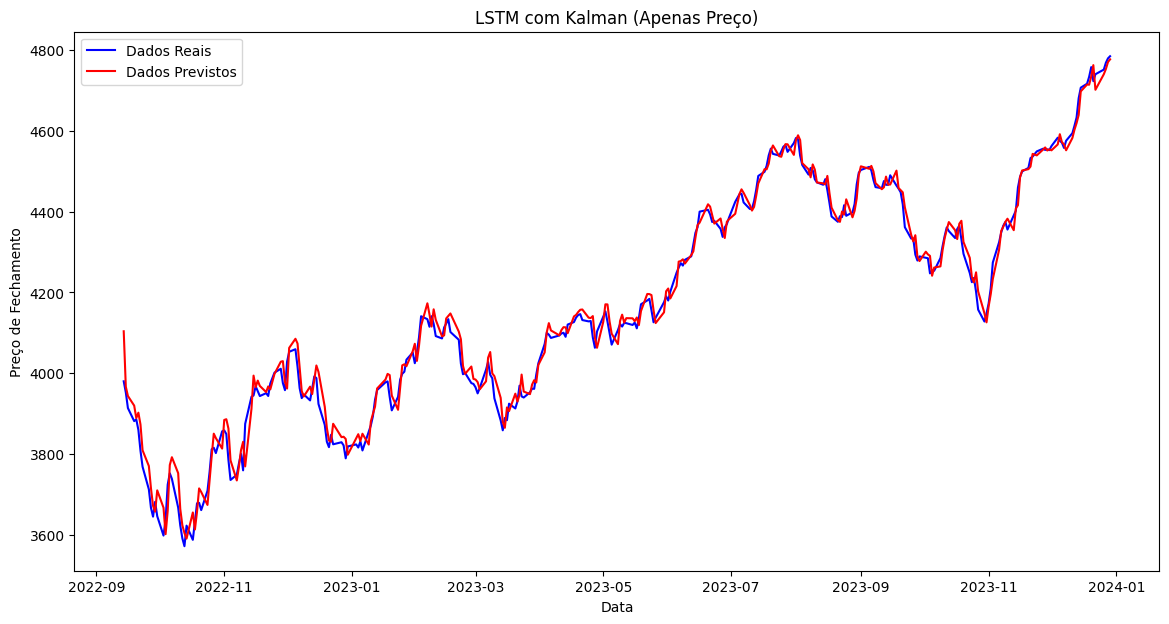

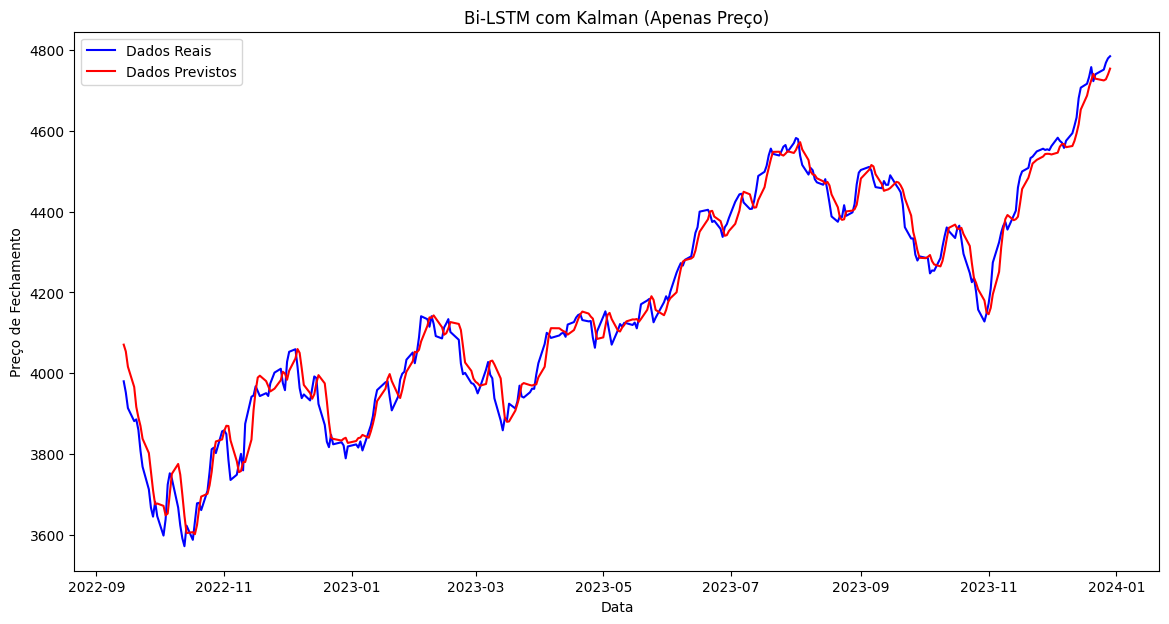

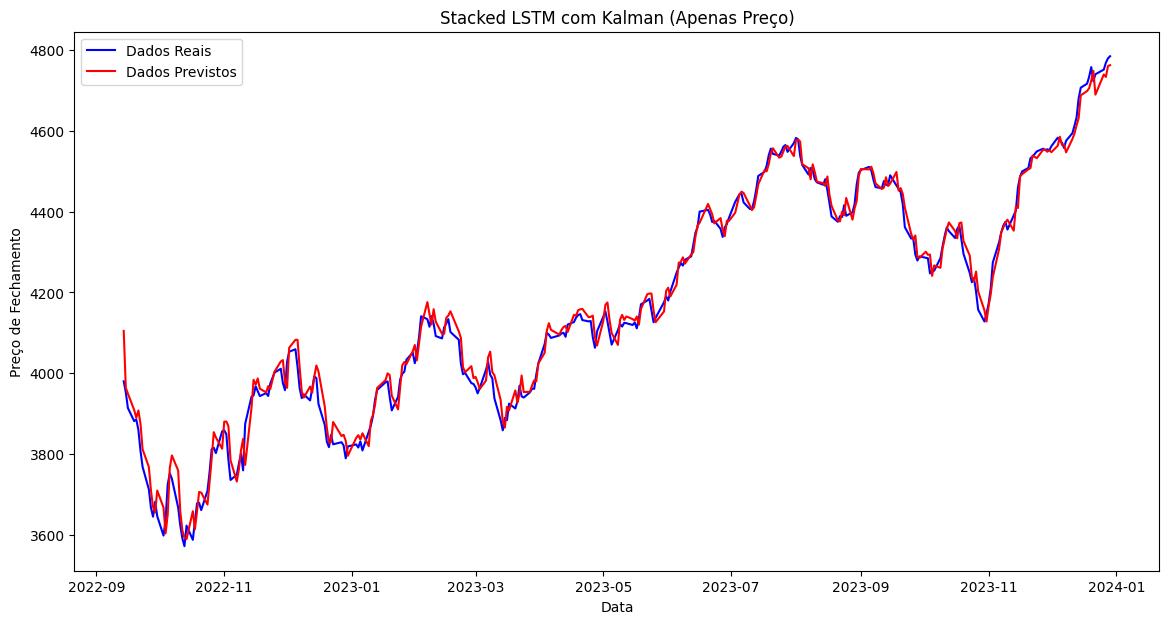

In [ ]:
# Plotando os resultados para LSTM com Kalman
plot_results(data, y_kalman_val_actual, predicted_kalman_basic, title='LSTM com Kalman (Apenas Preço)')

# Plotando os resultados para Bi-LSTM com Kalman
plot_results(data, y_kalman_val_actual, predicted_kalman_bi_close, title='Bi-LSTM com Kalman (Apenas Preço)')

# Plotando os resultados para Stacked LSTM com Kalman
plot_results(data, y_kalman_val_actual, predicted_kalman_stacked_close, title='Stacked LSTM com Kalman (Apenas Preço)')

Trial 10 Complete [00h 48m 35s]
val_loss: 0.0007900083903223277

Best val_loss So Far: 0.0003029086103197187
Total elapsed time: 3d 19h 39m 12s
Epoch 1/150


c:\Users\Jhoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 811ms/step - loss: 0.0204 - val_loss: 0.0040
Epoch 2/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 782ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 3/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 780ms/step - loss: 7.5219e-04 - val_loss: 5.0643e-04
Epoch 4/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 779ms/step - loss: 6.0844e-04 - val_loss: 3.9869e-04
Epoch 5/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 771ms/step - loss: 5.7703e-04 - val_loss: 3.2662e-04
Epoch 6/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 775ms/step - loss: 4.7953e-04 - val_loss: 2.8920e-04
Epoch 7/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 776ms/step - loss: 5.2062e-04 - val_loss: 3.9290e-04
Epoch 8/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 778ms/step - loss: 6.8209e-04 - val_loss: 0.0013
Epoch 9/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 779ms/step - loss: 8.2441e-04 - val_loss: 7.6539e-04
Epoch 10/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 778ms/step - loss: 5.3205e-04 - val_loss: 4.1825e-04
Epoch 11/150
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 777ms/step - loss: 6.8434e-

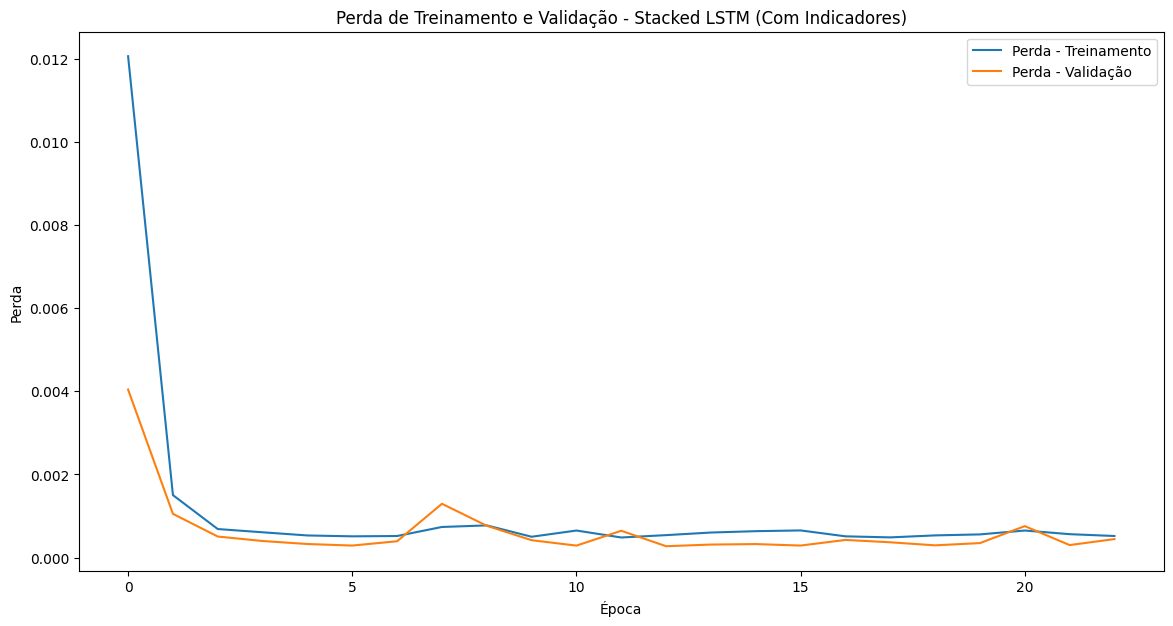

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step


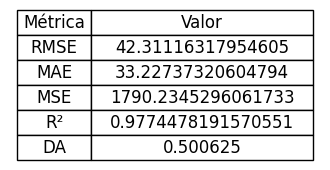

(42.31116317954605,
 33.22737320604794,
 1790.2345296061733,
 0.9774478191570551,
 0.500625)

In [ ]:
# Buscando os dados
data = fetch_data(ticker=TICKER, start_date=START_DATE, end_date=END_DATE)

# Dados Com Indicadores técnicos
data['SMA'] = SMA(data['Close'], window=SMA_WINDOW)
data['EMA'] = EMA(data['Close'], window=EMA_WINDOW)
data['RSI'] = RSI(data['Close'], window=RSI_WINDOW)
data = data.dropna()

scaler_tech = MinMaxScaler(feature_range=(0, 1))
scaled_data_tech = scaler_tech.fit_transform(data)
X_tech, Y_tech = create_dataset(scaled_data_tech, LOOK_BACK)
X_tech = np.reshape(X_tech, (X_tech.shape[0], X_tech.shape[1], X_tech.shape[2]))

# Dividindo os dados em treinamento e teste
X_train_tech, X_test_tech, Y_train_tech, Y_test_tech = split_data(X_tech, Y_tech, test_size=TEST_SIZE)

# Inversão da escala para obter os valores originais de treinamento e validação
y_tech_val_actual = scaler_close_only.inverse_transform(Y_test_tech.reshape(-1, 1))


# Definindo a forma de entrada
input_shape_2 = (LOOK_BACK, X_tech.shape[2])

# Executando a busca de hiperparâmetros
tuner_lstm = create_new_tuner(create_lstm_model, input_shape_2, project_name='tech_lstm_tuning')
tuner_lstm.search(X_train_tech, Y_train_tech, epochs=EPOCHS, validation_data=(X_test_tech, Y_test_tech), callbacks=[early_stopping], verbose=SHOW_DETAILS)

# Obtendo o melhor modelo
best_model_lstm_tech = tuner_lstm.get_best_models(num_models=1)[0]

# Treinamento e previsões para LSTM com indicadores técnicos
predicted_tech = train_and_predict_model('LSTM (Com Indicadores)', best_model_lstm_tech, X_train_tech, Y_train_tech, X_test_tech, Y_test_tech)
predicted_tech_full = np.zeros((predicted_tech.shape[0], scaled_data_tech.shape[1]))
predicted_tech_full[:, 0] = predicted_tech[:, 0]
predicted_tech = scaler_tech.inverse_transform(predicted_tech_full)[:, 0]

# Função para avaliar o modelo
evaluate_model(predicted_tech, y_tech_val_actual,'LSTM (Com Indicadores)')


# Executando a busca de hiperparâmetros
tuner_bilstm = create_new_tuner(create_bilstm_model, input_shape_2, project_name='tech_bilstm_tuning')
tuner_bilstm.search(X_train_tech, Y_train_tech, epochs=EPOCHS, validation_data=(X_test_tech, Y_test_tech), callbacks=[early_stopping], verbose=SHOW_DETAILS)

# Obtendo o melhor modelo
best_model_bilstm_tech = tuner_bilstm.get_best_models(num_models=1)[0]

# Treinamento e previsões para Bi-LSTM com indicadores técnicos
predicted_bi_tech = train_and_predict_model('Bi-LSTM (Com Indicadores)', best_model_bilstm_tech, X_train_tech, Y_train_tech, X_test_tech, Y_test_tech)
predicted_bi_tech_full = np.zeros((predicted_bi_tech.shape[0], scaled_data_tech.shape[1]))
predicted_bi_tech_full[:, 0] = predicted_bi_tech[:, 0]
predicted_bi_tech = scaler_tech.inverse_transform(predicted_bi_tech_full)[:, 0]

# Função para avaliar o modelo
evaluate_model(predicted_bi_tech, y_tech_val_actual, 'Bi-LSTM (Com Indicadores)')


# Executando a busca de hiperparâmetros
tuner_stacked = create_new_tuner(create_stacked_lstm_model, input_shape_2, project_name='tech_stacked_lstm_tuning')
tuner_stacked.search(X_train_tech, Y_train_tech, epochs=EPOCHS, validation_data=(X_test_tech, Y_test_tech), callbacks=[early_stopping], verbose=SHOW_DETAILS)

# Obtendo o melhor modelo
best_model_stacked_tech = tuner_stacked.get_best_models(num_models=1)[0]

# Treinamento e previsões para Stacked LSTM com indicadores técnicos
predicted_stacked_tech = train_and_predict_model('Stacked LSTM (Com Indicadores)', best_model_stacked_tech, X_train_tech, Y_train_tech, X_test_tech, Y_test_tech)
predicted_stacked_tech_full = np.zeros((predicted_stacked_tech.shape[0], scaled_data_tech.shape[1]))
predicted_stacked_tech_full[:, 0] = predicted_stacked_tech[:, 0]
predicted_stacked_tech = scaler_tech.inverse_transform(predicted_stacked_tech_full)[:, 0]

# Função para avaliar o modelo
evaluate_model(predicted_stacked_tech, y_tech_val_actual, 'Stacked LSTM (Com Indicadores)')

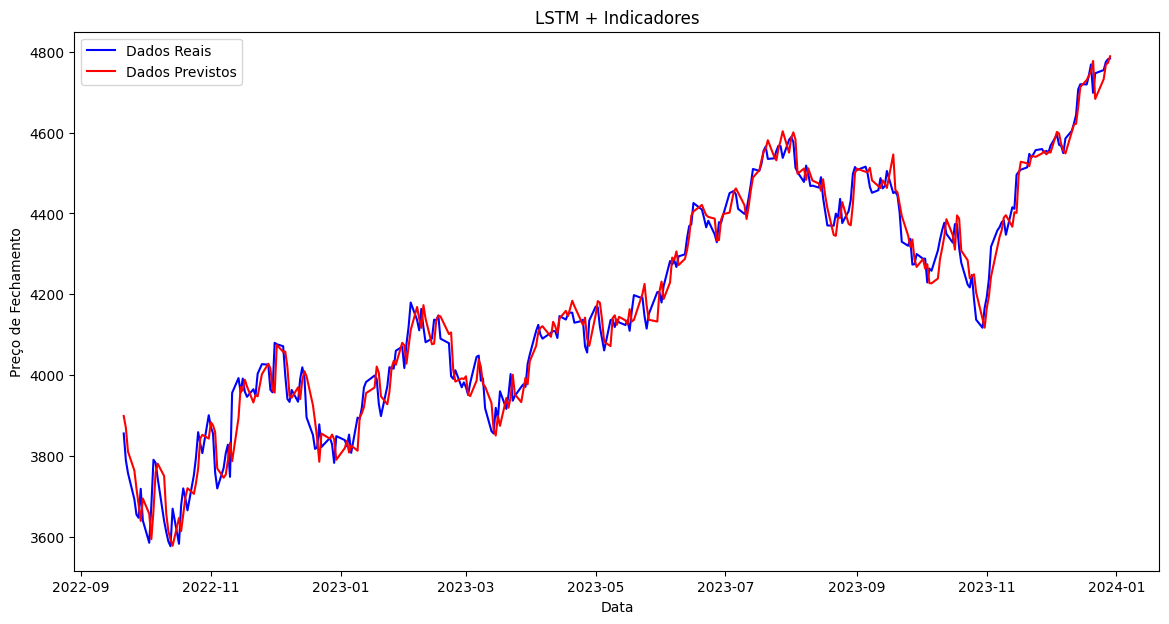

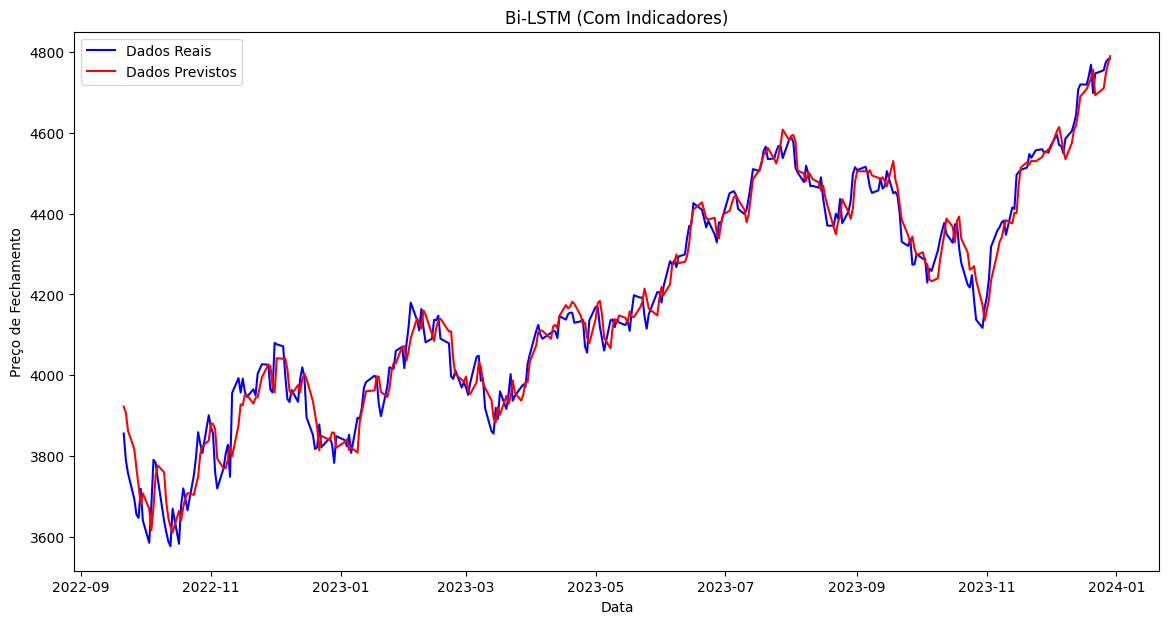

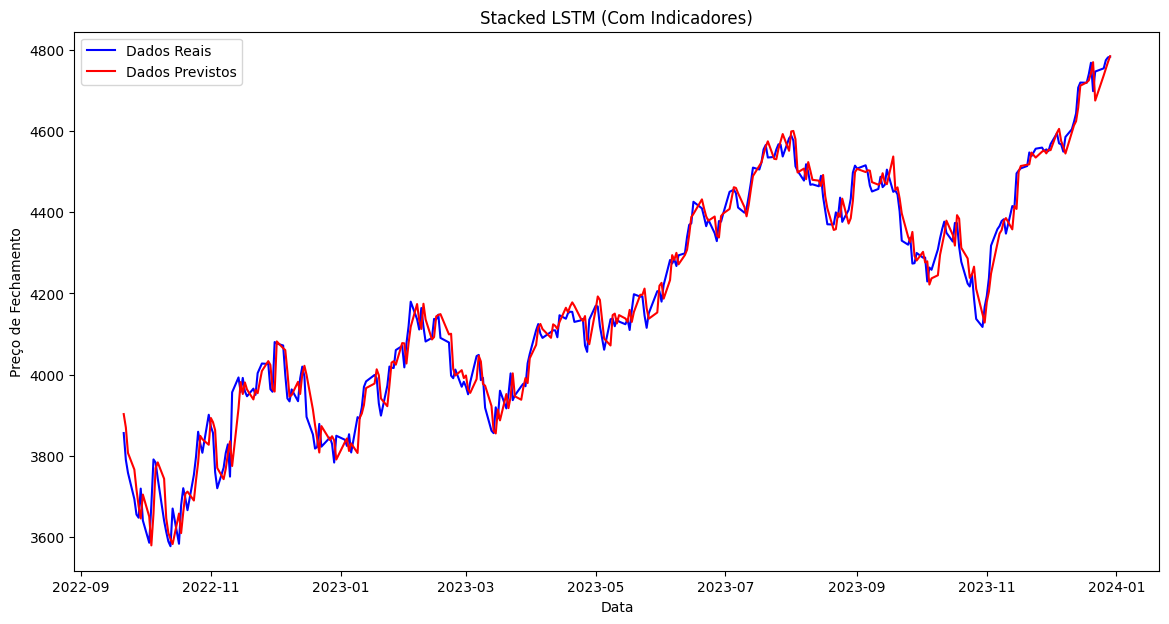

In [ ]:
# Para plotar os resultados, não precisamos inverter a escala de Y_test_tech com o scaler de múltiplas colunas.
# Podemos fazer a transformação inversa manualmente apenas para a coluna de fechamento.
Y_test_tech_inverted = scaler_tech.inverse_transform(
    np.concatenate([Y_test_tech.reshape(-1, 1), np.zeros((Y_test_tech.shape[0], scaled_data_tech.shape[1] - 1))], axis=1)
)[:, 0]

# Plotando os resultados para LSTM com indicadores técnicos
plot_results(data.iloc[-len(Y_test_tech):], Y_test_tech_inverted, predicted_tech, title='LSTM + Indicadores')

# Plotando os resultados para Bi-LSTM com indicadores técnicos
plot_results(data.iloc[-len(Y_test_tech):], Y_test_tech_inverted, predicted_bi_tech, title='Bi-LSTM (Com Indicadores)')

# Plotando os resultados para Stacked LSTM com indicadores técnicos
plot_results(data.iloc[-len(Y_test_tech):], Y_test_tech_inverted, predicted_stacked_tech, title='Stacked LSTM (Com Indicadores)')

In [ ]:
# Buscando os dados
data = fetch_data(ticker=TICKER, start_date=START_DATE, end_date=END_DATE)

# Aplicando o filtro de Kalman nos preços de fechamento
kalman_result = kalman_filter(data)

# Transformando o resultado do filtro em um DataFrame
kalman_filtered_data = pd.DataFrame(kalman_result, columns=['Close'])

# Continuando com o cálculo dos indicadores técnicos
kalman_filtered_data['SMA'] = SMA(kalman_filtered_data['Close'], window=SMA_WINDOW)
kalman_filtered_data['EMA'] = EMA(kalman_filtered_data['Close'], window=EMA_WINDOW)
kalman_filtered_data['RSI'] = RSI(kalman_filtered_data['Close'], window=RSI_WINDOW)
kalman_filtered_data = kalman_filtered_data.dropna()

scaler_kalman_tech = MinMaxScaler(feature_range=(0, 1))
scaled_kalman_data_tech = scaler_kalman_tech.fit_transform(kalman_filtered_data)
X_kalman_tech, Y_kalman_tech = create_dataset(scaled_kalman_data_tech, LOOK_BACK)
X_kalman_tech = np.reshape(X_kalman_tech, (X_kalman_tech.shape[0], X_kalman_tech.shape[1], X_kalman_tech.shape[2]))

# Dividindo os dados em treinamento e teste
X_train_kalman_tech, X_test_kalman_tech, Y_train_kalman_tech, Y_test_kalman_tech = split_data(X_kalman_tech, Y_kalman_tech, test_size=TEST_SIZE)

# Inversão da escala para obter os valores originais de treinamento e validação
y_kalman_tech_val_actual = scaler_close_only.inverse_transform(Y_test_kalman_tech.reshape(-1, 1))


# Definindo a forma de entrada
input_shape_2 = (LOOK_BACK, X_kalman_tech.shape[2])

# Executando a busca de hiperparâmetros
tuner_lstm = create_new_tuner(create_lstm_model, input_shape_2, project_name='kalman_tech_lstm_tuning')
tuner_lstm.search(X_train_kalman_tech, Y_train_kalman_tech, epochs=EPOCHS, validation_data=(X_test_kalman_tech, Y_test_kalman_tech), callbacks=[early_stopping], verbose=SHOW_DETAILS)

# Obtendo o melhor modelo
best_model_lstm_kalman_tech = tuner_lstm.get_best_models(num_models=1)[0]

# Treinamento e previsões para LSTM com Kalman e Indicadores Técnicos
# model_kalman_tech = create_lstm_model((LOOK_BACK, X_kalman_tech.shape[2]))
predicted_kalman_tech = train_and_predict_model('LSTM com Kalman (Com Indicadores)', best_model_lstm_kalman_tech, X_train_kalman_tech, Y_train_kalman_tech, X_test_kalman_tech, Y_test_kalman_tech)
predicted_kalman_tech_full = np.zeros((predicted_kalman_tech.shape[0], scaled_kalman_data_tech.shape[1]))
predicted_kalman_tech_full[:, 0] = predicted_kalman_tech[:, 0]

# Inversão da escala para obter os valores originais de treinamento e validação
predicted_kalman_tech = scaler_kalman_tech.inverse_transform(predicted_kalman_tech_full)[:, 0]

# Função para avaliar o modelo
evaluate_model(predicted_kalman_tech, y_kalman_tech_val_actual, 'LSTM com Kalman (Com Indicadores)')



# Executando a busca de hiperparâmetros
tuner_bilstm = create_new_tuner(create_bilstm_model, input_shape_2, project_name='kalman_tech_bilstm_tuning')
tuner_bilstm.search(X_train_kalman_tech, Y_train_kalman_tech, epochs=EPOCHS, validation_data=(X_test_kalman_tech, Y_test_kalman_tech), callbacks=[early_stopping], verbose=SHOW_DETAILS)

# Obtendo o melhor modelo
best_model_bilstm_kalman_tech = tuner_bilstm.get_best_models(num_models=1)[0]

# Treinamento e previsões para Bi-LSTM com Kalman e Indicadores Técnicos
# model_kalman_bi_tech = create_bilstm_model((LOOK_BACK, X_kalman_tech.shape[2]))
predicted_kalman_bi_tech = train_and_predict_model('Bi-LSTM com Kalman (Com Indicadores)', best_model_bilstm_kalman_tech, X_train_kalman_tech, Y_train_kalman_tech, X_test_kalman_tech, Y_test_kalman_tech)
predicted_kalman_bi_tech_full = np.zeros((predicted_kalman_bi_tech.shape[0], scaled_kalman_data_tech.shape[1]))
predicted_kalman_bi_tech_full[:, 0] = predicted_kalman_bi_tech[:, 0]

# Inversão da escala para obter os valores originais de treinamento e validação
predicted_kalman_bi_tech = scaler_kalman_tech.inverse_transform(predicted_kalman_bi_tech_full)[:, 0]

# Função para avaliar o modelo
evaluate_model(predicted_kalman_bi_tech, y_kalman_tech_val_actual, 'Bi-LSTM com Kalman (Com Indicadores)')



# Executando a busca de hiperparâmetros
tuner_stacked = create_new_tuner(create_stacked_lstm_model, input_shape_2, project_name='kalman_tech_stacked_lstm_tuning')
tuner_stacked.search(X_train_kalman_tech, Y_train_kalman_tech, epochs=EPOCHS, validation_data=(X_test_kalman_tech, Y_test_kalman_tech), callbacks=[early_stopping], verbose=SHOW_DETAILS)

# Obtendo o melhor modelo
best_model_stacked_kalman_tech = tuner_stacked.get_best_models(num_models=1)[0]

# Treinamento e previsões para Stacked LSTM com Kalman e Indicadores Técnicos
# model_kalman_stacked_tech = create_stacked_lstm_model((LOOK_BACK, X_kalman_tech.shape[2]))
predicted_kalman_stacked_tech = train_and_predict_model('Stacked LSTM com Kalman (Com Indicadores)', best_model_stacked_kalman_tech, X_train_kalman_tech, Y_train_kalman_tech, X_test_kalman_tech, Y_test_kalman_tech)
predicted_kalman_stacked_tech_full = np.zeros((predicted_kalman_stacked_tech.shape[0], scaled_kalman_data_tech.shape[1]))
predicted_kalman_stacked_tech_full[:, 0] = predicted_kalman_stacked_tech[:, 0]

# Inversão da escala para obter os valores originais de treinamento e validação
predicted_kalman_stacked_tech = scaler_kalman_tech.inverse_transform(predicted_kalman_stacked_tech_full)[:, 0]

# Função para avaliar o modelo
evaluate_model(predicted_kalman_stacked_tech, y_kalman_tech_val_actual, 'Stacked LSTM com Kalman (Com Indicadores)')

[*********************100%***********************]  1 of 1 completed


Reloading Tuner from my_dir_kalman_tech_lstm_tuning\kalman_tech_lstm_tuning\tuner0.json


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000002A690244D60>
Traceback (most recent call last):
  File "c:\Users\Jhoe\AppData\Local\Programs\Python\Python312\Lib\weakref.py", line 370, in remove
    self = selfref()
           ^^^^^^^^^
KeyboardInterrupt: 


Epoch 1/150


c:\Users\Jhoe\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 5/21 ━━━━━━━━━━━━━━━━━━━━ 11s 695ms/step - loss: 0.0047

KeyboardInterrupt: 

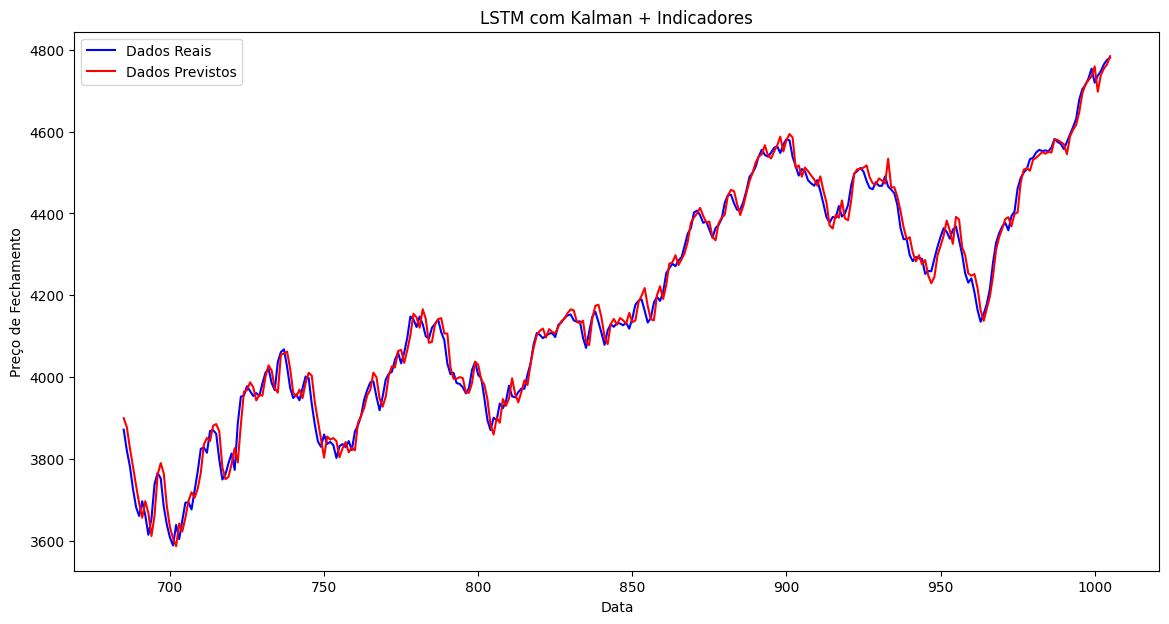

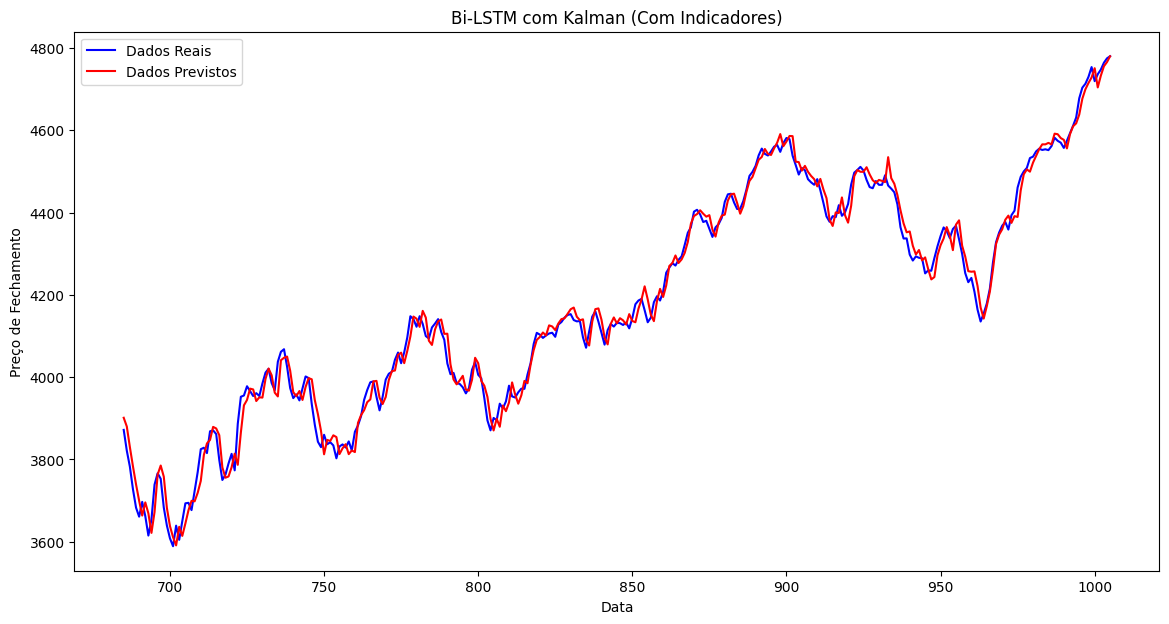

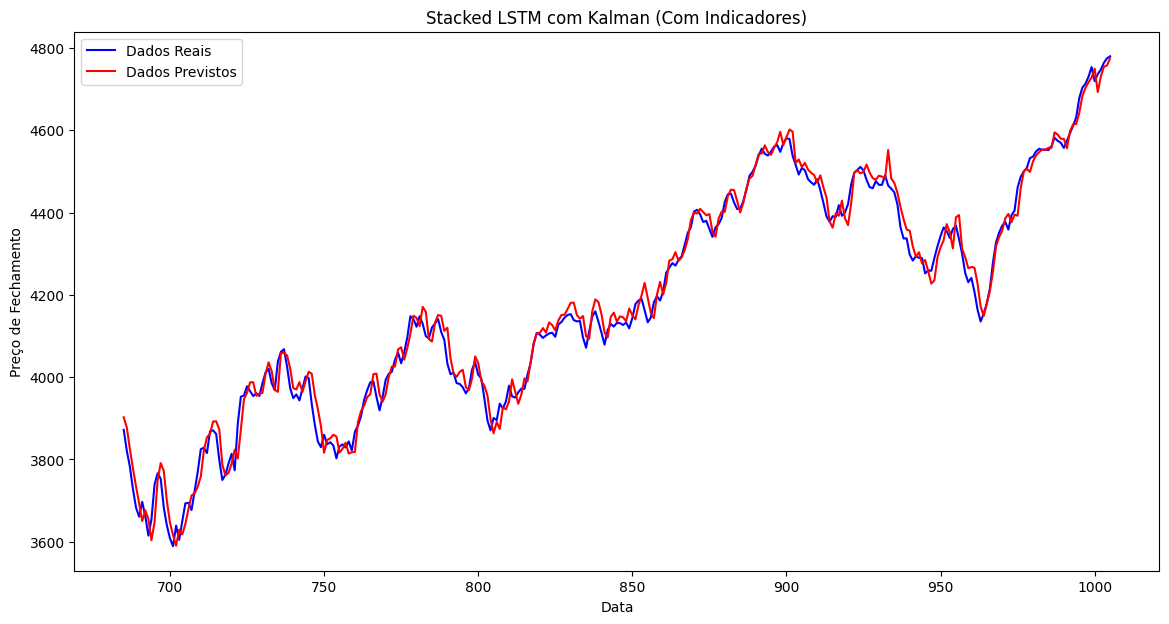

In [ ]:
# Para plotar os resultados, não precisamos inverter a escala de Y_test_kalman_tech com o scaler de múltiplas colunas.
# Podemos fazer a transformação inversa manualmente apenas para a coluna de fechamento.
Y_test_kalman_tech_inverted = scaler_kalman_tech.inverse_transform(
    np.concatenate([Y_test_kalman_tech.reshape(-1, 1), np.zeros((Y_test_kalman_tech.shape[0], scaled_kalman_data_tech.shape[1] - 1))], axis=1)
)[:, 0]

# Plotando os resultados para LSTM com Kalman e Indicadores Técnicos
plot_results(kalman_filtered_data.iloc[-len(Y_test_kalman_tech):], Y_test_kalman_tech_inverted, predicted_kalman_tech, title='LSTM com Kalman + Indicadores')

# Plotando os resultados para Bi-LSTM com Kalman e Indicadores Técnicos
plot_results(kalman_filtered_data.iloc[-len(Y_test_kalman_tech):], Y_test_kalman_tech_inverted, predicted_kalman_bi_tech, title='Bi-LSTM com Kalman (Com Indicadores)')

# Plotando os resultados para Stacked LSTM com Kalman e Indicadores Técnicos
plot_results(kalman_filtered_data.iloc[-len(Y_test_kalman_tech):], Y_test_kalman_tech_inverted, predicted_kalman_stacked_tech, title='Stacked LSTM com Kalman (Com Indicadores)')


Predicted Close Price with Basic LSTM: 4767.9580078125
Predicted Close Price with LSTM + Technical Indicators: 4788.884812499164
Predicted Close Price with Bi-LSTM (Apenas Preço): 4767.34130859375
Predicted Close Price with Stacked LSTM (Apenas Preço): 4763.5048828125
Predicted Close Price with Bi-LSTM (Com Indicadores): 4789.373696250841
Predicted Close Price with Stacked LSTM (Com Indicadores): 4784.508349560201
Predicted Close Price with LSTM com Kalman (Apenas Preço): 4777.7373046875
Predicted Close Price with LSTM com Kalman (Com Indicadores): 4784.0898798875705
Predicted Close Price with Bi-LSTM com Kalman (Apenas Preço): 4754.6591796875
Predicted Close Price with Stacked LSTM com Kalman (Apenas Preço): 4763.30078125
Predicted Close Price with Bi-LSTM com Kalman (Com Indicadores): 4779.992138255586
Predicted Close Price with Stacked LSTM com Kalman (Com Indicadores): 4775.425822464522
Loss with Basic LSTM: 0.000377566582756117
Loss with LSTM + Technical Indicators: 0.000403661018

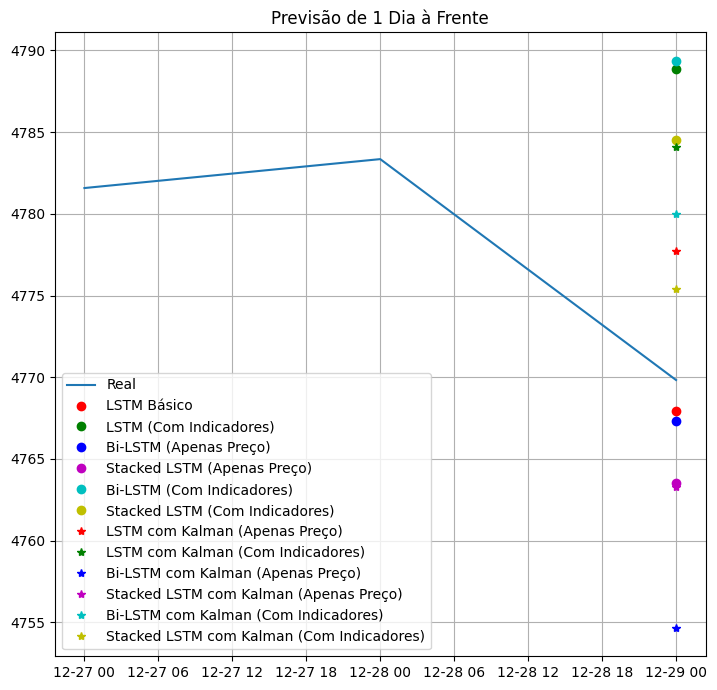

In [ ]:
# Comparação dos Resultados
print(f"Predicted Close Price with Basic LSTM: {predicted_basic[-1][-1]}")
print(f"Predicted Close Price with LSTM + Technical Indicators: {predicted_tech[-1]}")
print(f"Predicted Close Price with Bi-LSTM (Apenas Preço): {predicted_bi_close[-1][-1]}")
print(f"Predicted Close Price with Stacked LSTM (Apenas Preço): {predicted_stacked_close[-1][-1]}")
print(f"Predicted Close Price with Bi-LSTM (Com Indicadores): {predicted_bi_tech[-1]}")
print(f"Predicted Close Price with Stacked LSTM (Com Indicadores): {predicted_stacked_tech[-1]}")

print(f"Predicted Close Price with LSTM com Kalman (Apenas Preço): {predicted_kalman_basic[-1][-1]}")
print(f"Predicted Close Price with LSTM com Kalman (Com Indicadores): {predicted_kalman_tech[-1]}")
print(f"Predicted Close Price with Bi-LSTM com Kalman (Apenas Preço): {predicted_kalman_bi_close[-1][-1]}")
print(f"Predicted Close Price with Stacked LSTM com Kalman (Apenas Preço): {predicted_kalman_stacked_close[-1][-1]}")
print(f"Predicted Close Price with Bi-LSTM com Kalman (Com Indicadores): {predicted_kalman_bi_tech[-1]}")
print(f"Predicted Close Price with Stacked LSTM com Kalman (Com Indicadores): {predicted_kalman_stacked_tech[-1]}")

# Validando os Losses
loss_basic = best_model_lstm_basic.evaluate(X_basic, Y_basic, verbose=0)
loss_tech = best_model_lstm_tech.evaluate(X_tech, Y_tech, verbose=0)
loss_bi_close = best_model_bilstm_basic.evaluate(X_basic, Y_basic, verbose=0)
loss_stacked_close = best_model_stacked_basic.evaluate(X_basic, Y_basic, verbose=0)
loss_bi_tech = best_model_bilstm_tech.evaluate(X_tech, Y_tech, verbose=0)
loss_stacked_tech = best_model_stacked_tech.evaluate(X_tech, Y_tech, verbose=0)

loss_kalman_basic = best_model_lstm_kalman.evaluate(X_kalman_basic, Y_kalman_basic, verbose=0)
loss_kalman_tech = best_model_lstm_kalman_tech.evaluate(X_kalman_tech, Y_kalman_tech, verbose=0)
loss_kalman_bi_close = best_model_bilstm_kalman.evaluate(X_kalman_basic, Y_kalman_basic, verbose=0)
loss_kalman_stacked_close = best_model_stacked_kalman.evaluate(X_kalman_basic, Y_kalman_basic, verbose=0)
loss_kalman_bi_tech = best_model_bilstm_kalman_tech.evaluate(X_kalman_tech, Y_kalman_tech, verbose=0)
loss_kalman_stacked_tech = best_model_stacked_kalman_tech.evaluate(X_kalman_tech, Y_kalman_tech, verbose=0)

print(f"Loss with Basic LSTM: {loss_basic}")
print(f"Loss with LSTM + Technical Indicators: {loss_tech}")
print(f"Loss with Bi-LSTM (Apenas Preço): {loss_bi_close}")
print(f"Loss with Stacked LSTM (Apenas Preço): {loss_stacked_close}")
print(f"Loss with Bi-LSTM (Com Indicadores): {loss_bi_tech}")
print(f"Loss with Stacked LSTM (Com Indicadores): {loss_stacked_tech}")

print(f"Loss with LSTM com Kalman (Apenas Preço): {loss_kalman_basic}")
print(f"Loss with LSTM com Kalman (Com Indicadores): {loss_kalman_tech}")
print(f"Loss with Bi-LSTM com Kalman (Apenas Preço): {loss_kalman_bi_close}")
print(f"Loss with Stacked LSTM com Kalman (Apenas Preço): {loss_kalman_stacked_close}")
print(f"Loss with Bi-LSTM com Kalman (Com Indicadores): {loss_kalman_bi_tech}")
print(f"Loss with Stacked LSTM com Kalman (Com Indicadores): {loss_kalman_stacked_tech}")

# Plotando previsões de 1 dia
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.title("Previsão de 1 Dia à Frente")
plt.plot(data.index[-DAYS_AHEAD:], data['Close'].values[-DAYS_AHEAD:], label='Real')
plt.plot(data.index[-1], predicted_basic[-1], 'ro', label='LSTM Básico')
plt.plot(data.index[-1], predicted_tech[-1], 'go', label='LSTM (Com Indicadores)')
plt.plot(data.index[-1], predicted_bi_close[-1], 'bo', label='Bi-LSTM (Apenas Preço)')
plt.plot(data.index[-1], predicted_stacked_close[-1], 'mo', label='Stacked LSTM (Apenas Preço)')
plt.plot(data.index[-1], predicted_bi_tech[-1], 'co', label='Bi-LSTM (Com Indicadores)')
plt.plot(data.index[-1], predicted_stacked_tech[-1], 'yo', label='Stacked LSTM (Com Indicadores)')

plt.plot(data.index[-1], predicted_kalman_basic[-1], 'r*', label='LSTM com Kalman (Apenas Preço)')
plt.plot(data.index[-1], predicted_kalman_tech[-1], 'g*', label='LSTM com Kalman (Com Indicadores)')
plt.plot(data.index[-1], predicted_kalman_bi_close[-1], 'b*', label='Bi-LSTM com Kalman (Apenas Preço)')
plt.plot(data.index[-1], predicted_kalman_stacked_close[-1], 'm*', label='Stacked LSTM com Kalman (Apenas Preço)')
plt.plot(data.index[-1], predicted_kalman_bi_tech[-1], 'c*', label='Bi-LSTM com Kalman (Com Indicadores)')
plt.plot(data.index[-1], predicted_kalman_stacked_tech[-1], 'y*', label='Stacked LSTM com Kalman (Com Indicadores)')

plt.legend()
plt.grid(True)
plt.tight_layout()  # Ajusta o layout para que as legendas se encaixem bem

In [ ]:
def get_future_index_and_real_prices(ticker, data, days_ahead):

    # Calcular o número de dias extras para garantir 'days_ahead' dias úteis
    extra_days = 2 * days_ahead

    # Obter os próximos dias úteis de negociação usando yfinance
    next_days = yf.download(ticker,
                            start=data.index[-1] + pd.Timedelta(days=1),
                            end=data.index[-1] + pd.Timedelta(days=days_ahead + extra_days))

    # Selecionar os primeiros 'days_ahead' dias úteis dos próximos dias
    extended_index = next_days.index[:days_ahead]

    # Concatenar os últimos dados reais com os dados futuros para os preços de fechamento
    extended_real_close = np.concatenate([
        data['Close'].values[-days_ahead:],
        next_days['Close'].values[:days_ahead]
    ])

    # Criar um índice combinado para plotagem que inclui os dias reais e futuros
    plot_index = np.concatenate([
        data.index[-days_ahead:],
        extended_index
    ])

    return plot_index, extended_real_close, extended_index

def multi_day_predict(model, current_input, look_back, days_ahead):
    # Inicializa a lista de previsões
    predictions = []

    # Ajusta o formato da entrada atual para o modelo
    current_input = np.reshape(current_input, (1, look_back, current_input.shape[1]))

    for _ in range(days_ahead):
        # Faz a previsão para o próximo dia
        pred = model.predict(current_input)
        predictions.append(pred[0, 0])  # Armazena a previsão

        # Atualiza a entrada atual para a próxima iteração
        current_input = np.roll(current_input, -1, axis=1)
        current_input[0, -1, 0] = pred.item()  # Adiciona a nova previsão ao final

    return np.array(predictions)

[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[4767.9575 4749.3965 4729.8726]
[4781.58007812 4783.35009766 4769.83007812 4742.83007812 4704.81005859
 4688.68017578]


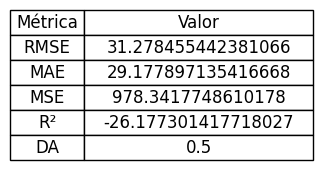

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


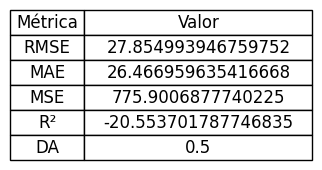

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


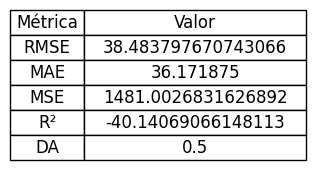

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


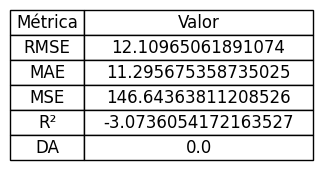

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


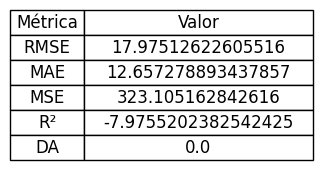

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


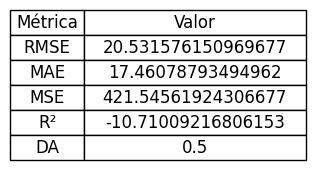

(20.531576150969677,
 17.46078793494962,
 421.54561924306677,
 -10.71009216806153,
 0.5)

In [ ]:
#
plot_index, extended_real_close, extended_index = get_future_index_and_real_prices(TICKER, data, DAYS_AHEAD)

# Previsão de X dias à frente
predicted_basic_AHEAD = multi_day_predict(best_model_lstm_basic, X_basic[-1], LOOK_BACK, DAYS_AHEAD)
# Inversão da escala para obter os valores originais de treinamento e validação
predicted_basic_AHEAD = scaler_close_only.inverse_transform(predicted_basic_AHEAD.reshape(-1, 1))

print(predicted_basic_AHEAD.flatten())
print(extended_real_close)

# Função para avaliar o modelo
evaluate_model(predicted_basic_AHEAD.flatten(), extended_real_close[:DAYS_AHEAD], 'LSTM Básico')

predicted_bi_close_AHEAD = multi_day_predict(best_model_bilstm_basic, X_basic[-1], LOOK_BACK, DAYS_AHEAD)
# Inversão da escala para obter os valores originais de treinamento e validação
predicted_bi_close_AHEAD = scaler_close_only.inverse_transform(predicted_bi_close_AHEAD.reshape(-1, 1))
# Função para avaliar o modelo
evaluate_model(predicted_bi_close_AHEAD, extended_real_close[:DAYS_AHEAD], 'Bi-LSTM (Apenas Preço)')

predicted_stacked_close_AHEAD = multi_day_predict(best_model_stacked_basic, X_basic[-1], LOOK_BACK, DAYS_AHEAD)
# Inversão da escala para obter os valores originais de treinamento e validação
predicted_stacked_close_AHEAD = scaler_close_only.inverse_transform(predicted_stacked_close_AHEAD.reshape(-1, 1))
# Função para avaliar o modelo
evaluate_model(predicted_stacked_close_AHEAD, extended_real_close[:DAYS_AHEAD], 'Stacked LSTM (Apenas Preço)')

# Com indicadores tecnicos

predicted_tech_AHEAD = multi_day_predict(best_model_lstm_tech, X_tech[-1], LOOK_BACK, DAYS_AHEAD)
predicted_tech_AHEAD_full = np.zeros((predicted_tech_AHEAD.shape[0], scaled_data_tech.shape[1]))
predicted_tech_AHEAD_full[:, 0] = predicted_tech_AHEAD
# Inversão da escala para obter os valores originais de treinamento e validação
predicted_tech_AHEAD = scaler_tech.inverse_transform(predicted_tech_AHEAD_full)[:, 0]
# Função para avaliar o modelo
evaluate_model(predicted_tech_AHEAD, extended_real_close[:DAYS_AHEAD], 'LSTM (Com Indicadores)')


predicted_bi_tech_AHEAD = multi_day_predict(best_model_bilstm_tech, X_tech[-1], LOOK_BACK, DAYS_AHEAD)
predicted_bi_tech_AHEAD_full = np.zeros((predicted_bi_tech_AHEAD.shape[0], scaled_data_tech.shape[1]))
predicted_bi_tech_AHEAD_full[:, 0] = predicted_bi_tech_AHEAD
# Inversão da escala para obter os valores originais de treinamento e validação
predicted_bi_tech_AHEAD = scaler_tech.inverse_transform(predicted_bi_tech_AHEAD_full)[:, 0]
# Função para avaliar o modelo
evaluate_model(predicted_bi_tech_AHEAD, extended_real_close[:DAYS_AHEAD], 'Bi-LSTM (Com Indicadores)')


predicted_stacked_tech_AHEAD = multi_day_predict(best_model_stacked_tech, X_tech[-1], LOOK_BACK, DAYS_AHEAD)
predicted_stacked_tech_AHEAD_full = np.zeros((predicted_stacked_tech_AHEAD.shape[0], scaled_data_tech.shape[1]))
predicted_stacked_tech_AHEAD_full[:, 0] = predicted_stacked_tech_AHEAD
# Inversão da escala para obter os valores originais de treinamento e validação
predicted_stacked_tech_AHEAD = scaler_tech.inverse_transform(predicted_stacked_tech_AHEAD_full)[:, 0]
# Função para avaliar o modelo
evaluate_model(predicted_stacked_tech_AHEAD, extended_real_close[:DAYS_AHEAD], 'Stacked LSTM (Com Indicadores)')

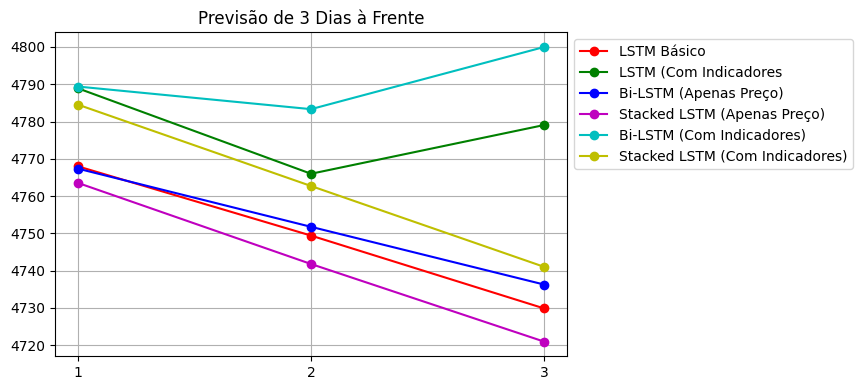

In [ ]:
# Plotando previsões de X dias à frente
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 2)
plt.xticks(range(1, DAYS_AHEAD + 1))
plt.title(f"Previsão de {DAYS_AHEAD} Dias à Frente")
plt.plot(range(1, DAYS_AHEAD + 1), predicted_basic_AHEAD, 'r-o', label='LSTM Básico')
plt.plot(range(1, DAYS_AHEAD + 1), predicted_tech_AHEAD, 'g-o', label='LSTM (Com Indicadores')
plt.plot(range(1, DAYS_AHEAD + 1), predicted_bi_close_AHEAD, 'b-o', label='Bi-LSTM (Apenas Preço)')
plt.plot(range(1, DAYS_AHEAD + 1), predicted_stacked_close_AHEAD, 'm-o', label='Stacked LSTM (Apenas Preço)')
plt.plot(range(1, DAYS_AHEAD + 1), predicted_bi_tech_AHEAD, 'c-o', label='Bi-LSTM (Com Indicadores)')
plt.plot(range(1, DAYS_AHEAD + 1), predicted_stacked_tech_AHEAD, 'y-o', label='Stacked LSTM (Com Indicadores)')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


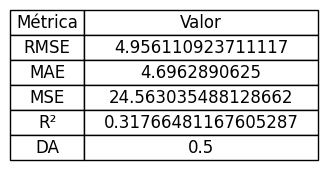

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


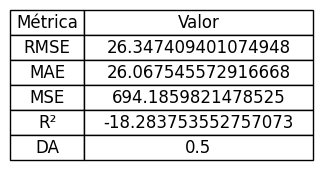

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


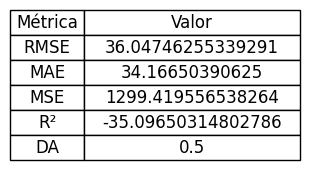

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


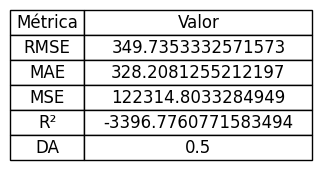

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


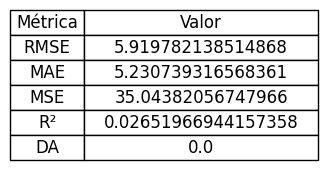

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


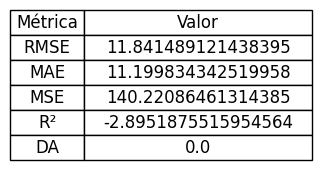

(11.841489121438395,
 11.199834342519958,
 140.22086461314385,
 -2.8951875515954564,
 0.0)

In [ ]:
# Previsão de AHEAD dias à frente com Kalman
predicted_kalman_basic_AHEAD = multi_day_predict(best_model_lstm_kalman, X_kalman_basic[-1], LOOK_BACK, DAYS_AHEAD)
predicted_kalman_basic_AHEAD = scaler_kalman_close_only.inverse_transform(predicted_kalman_basic_AHEAD.reshape(-1, 1))

# Função para avaliar o modelo
evaluate_model(predicted_kalman_basic_AHEAD, extended_real_close[:DAYS_AHEAD], 'LSTM com Kalman (Apenas Preço)')

predicted_kalman_bi_close_AHEAD = multi_day_predict(best_model_bilstm_kalman, X_kalman_basic[-1], LOOK_BACK, DAYS_AHEAD)
predicted_kalman_bi_close_AHEAD = scaler_kalman_close_only.inverse_transform(predicted_kalman_bi_close_AHEAD.reshape(-1, 1))

# Função para avaliar o modelo
evaluate_model(predicted_kalman_bi_close_AHEAD, extended_real_close[:DAYS_AHEAD],'Bi-LSTM com Kalman (Apenas Preço)')

predicted_kalman_stacked_close_AHEAD = multi_day_predict(best_model_stacked_kalman, X_kalman_basic[-1], LOOK_BACK, DAYS_AHEAD)
predicted_kalman_stacked_close_AHEAD = scaler_kalman_close_only.inverse_transform(predicted_kalman_stacked_close_AHEAD.reshape(-1, 1))

# Função para avaliar o modelo
evaluate_model(predicted_kalman_stacked_close_AHEAD, extended_real_close[:DAYS_AHEAD],'Stacked LSTM com Kalman (Apenas Preço)')

predicted_kalman_tech_AHEAD = multi_day_predict(best_model_lstm_kalman_tech, X_kalman_tech[-1], LOOK_BACK, DAYS_AHEAD)
predicted_kalman_tech_AHEAD_full = np.zeros((predicted_kalman_tech_AHEAD.shape[0], scaled_kalman_data_tech.shape[1]))
predicted_kalman_tech_AHEAD_full[:, 0] = predicted_kalman_tech_AHEAD
predicted_kalman_tech_AHEAD = scaler_kalman_tech.inverse_transform(predicted_kalman_tech_AHEAD_full)[:, 0]

# Função para avaliar o modelo
evaluate_model(predicted_kalman_tech_AHEAD, extended_real_close[:DAYS_AHEAD],  'LSTM com Kalman (Com Indicadores)')

predicted_kalman_bi_tech_AHEAD = multi_day_predict(best_model_bilstm_kalman_tech, X_kalman_tech[-1], LOOK_BACK, DAYS_AHEAD)
predicted_kalman_bi_tech_AHEAD_full = np.zeros((predicted_kalman_bi_tech_AHEAD.shape[0], scaled_kalman_data_tech.shape[1]))
predicted_kalman_bi_tech_AHEAD_full[:, 0] = predicted_kalman_bi_tech_AHEAD
predicted_kalman_bi_tech_AHEAD = scaler_kalman_tech.inverse_transform(predicted_kalman_bi_tech_AHEAD_full)[:, 0]

# Função para avaliar o modelo
evaluate_model(predicted_kalman_bi_tech_AHEAD, extended_real_close[:DAYS_AHEAD], 'Bi-LSTM com Kalman (Com Indicadores)')

predicted_kalman_stacked_tech_AHEAD = multi_day_predict(best_model_stacked_kalman_tech, X_kalman_tech[-1], LOOK_BACK, DAYS_AHEAD)
predicted_kalman_stacked_tech_AHEAD_full = np.zeros((predicted_kalman_stacked_tech_AHEAD.shape[0], scaled_kalman_data_tech.shape[1]))
predicted_kalman_stacked_tech_AHEAD_full[:, 0] = predicted_kalman_stacked_tech_AHEAD
predicted_kalman_stacked_tech_AHEAD = scaler_kalman_tech.inverse_transform(predicted_kalman_stacked_tech_AHEAD_full)[:, 0]

# Função para avaliar o modelo
evaluate_model(predicted_kalman_stacked_tech_AHEAD, extended_real_close[:DAYS_AHEAD], 'Stacked LSTM com Kalman (Com Indicadores)')

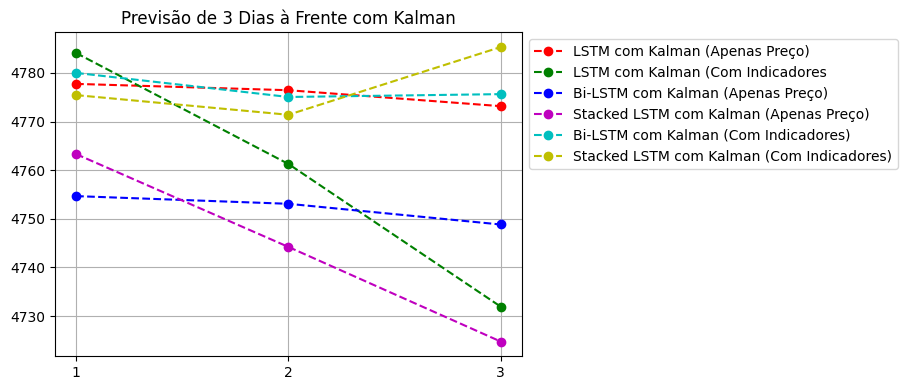

In [ ]:
# Plotando previsões de X dias à frente
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 2)
plt.xticks(range(1, DAYS_AHEAD + 1))
plt.title(f"Previsão de {DAYS_AHEAD} Dias à Frente com Kalman")
# Adicionando previsões com Kalman
plt.plot(range(1, DAYS_AHEAD + 1), predicted_kalman_basic_AHEAD, 'r--o', label='LSTM com Kalman (Apenas Preço)')
plt.plot(range(1, DAYS_AHEAD + 1), predicted_kalman_tech_AHEAD, 'g--o', label='LSTM com Kalman (Com Indicadores')
plt.plot(range(1, DAYS_AHEAD + 1), predicted_kalman_bi_close_AHEAD, 'b--o', label='Bi-LSTM com Kalman (Apenas Preço)')
plt.plot(range(1, DAYS_AHEAD + 1), predicted_kalman_stacked_close_AHEAD, 'm--o', label='Stacked LSTM com Kalman (Apenas Preço)')
plt.plot(range(1, DAYS_AHEAD + 1), predicted_kalman_bi_tech_AHEAD, 'c--o', label='Bi-LSTM com Kalman (Com Indicadores)')
plt.plot(range(1, DAYS_AHEAD + 1), predicted_kalman_stacked_tech_AHEAD, 'y--o', label='Stacked LSTM com Kalman (Com Indicadores)')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

plt.show()

[*********************100%***********************]  1 of 1 completed


['2023-12-27T00:00:00.000000000' '2023-12-28T00:00:00.000000000'
 '2023-12-29T00:00:00.000000000' '2024-01-02T00:00:00.000000000'
 '2024-01-03T00:00:00.000000000' '2024-01-04T00:00:00.000000000']
DatetimeIndex(['2024-01-02', '2024-01-03', '2024-01-04'], dtype='datetime64[ns]', name='Date', freq=None)
[4781.58007812 4783.35009766 4769.83007812 4742.83007812 4704.81005859
 4688.68017578]


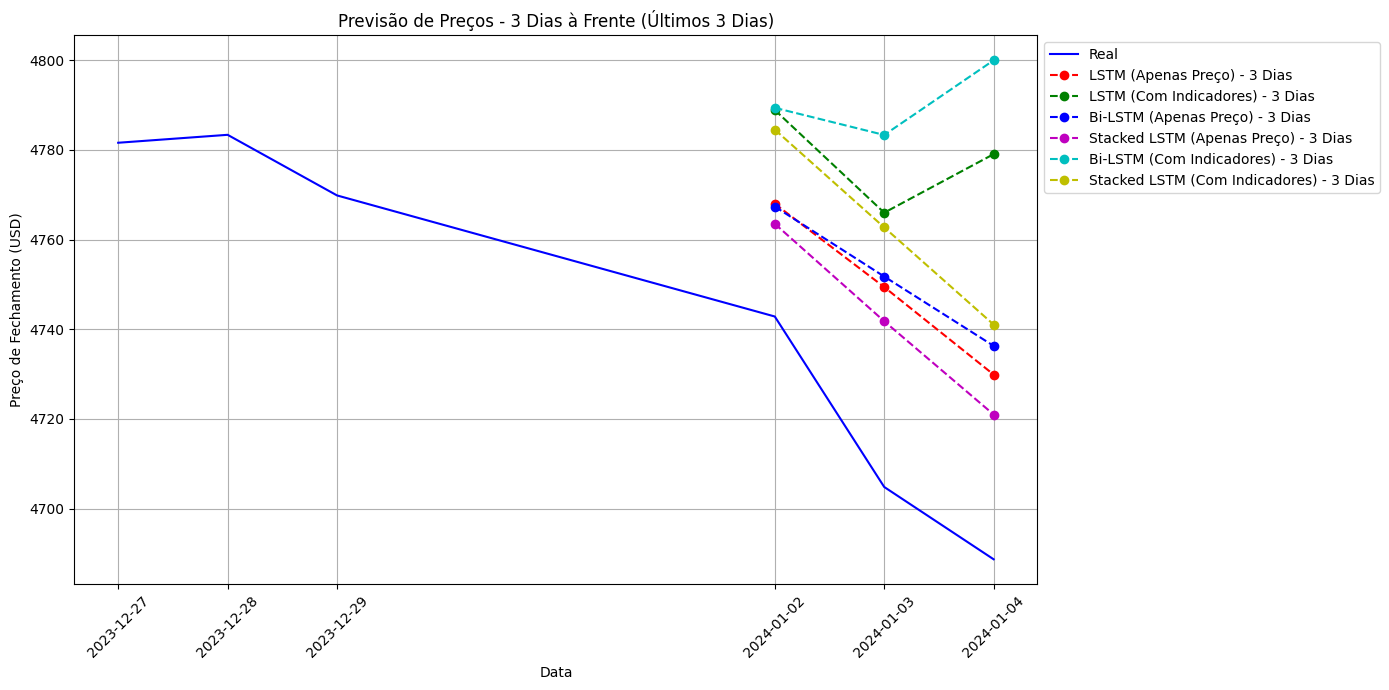

In [ ]:

plot_index, extended_real_close, extended_index = get_future_index_and_real_prices(TICKER, data, DAYS_AHEAD)

# Plotando os dados reais e as previsões de 10 dias
plt.figure(figsize=(14, 7))

print(plot_index)
print(extended_index)
print(extended_real_close)

# Plotando os últimos Y dias dos dados reais mais os próximos X dias reais
plt.plot(plot_index, extended_real_close, label='Real', color='blue')

# Previsões de X dias sem Kalman
plt.plot(extended_index, predicted_basic_AHEAD, 'r--o', label=f'LSTM (Apenas Preço) - {DAYS_AHEAD} Dias')
plt.plot(extended_index, predicted_tech_AHEAD, 'g--o', label=f'LSTM (Com Indicadores) - {DAYS_AHEAD} Dias')
plt.plot(extended_index, predicted_bi_close_AHEAD, 'b--o', label=f'Bi-LSTM (Apenas Preço) - {DAYS_AHEAD} Dias')
plt.plot(extended_index, predicted_stacked_close_AHEAD, 'm--o', label=f'Stacked LSTM (Apenas Preço) - {DAYS_AHEAD} Dias')
plt.plot(extended_index, predicted_bi_tech_AHEAD, 'c--o', label=f'Bi-LSTM (Com Indicadores) - {DAYS_AHEAD} Dias')
plt.plot(extended_index, predicted_stacked_tech_AHEAD, 'y--o', label=f'Stacked LSTM (Com Indicadores) - {DAYS_AHEAD} Dias')

# Ajustando o eixo x para mostrar todas as datas
plt.xticks(plot_index, rotation=45)
plt.title(f"Previsão de Preços - {DAYS_AHEAD} Dias à Frente (Últimos {int(np.ceil(DAYS_AHEAD * 0.8))} Dias)")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento (USD)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()  # Ajusta o layout para que as datas rotacionadas se encaixem bem
plt.show()

[*********************100%***********************]  1 of 1 completed


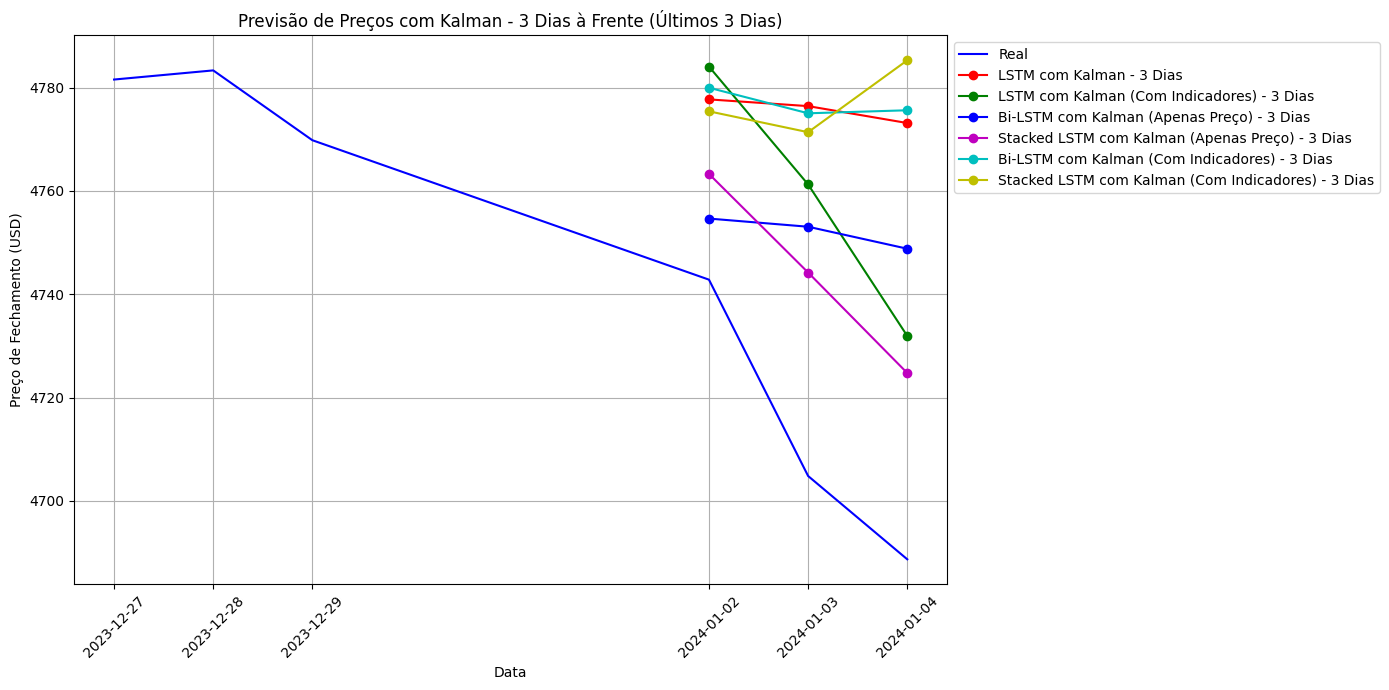

In [ ]:
plot_index, extended_real_close, extended_index = get_future_index_and_real_prices(TICKER, data, DAYS_AHEAD)

# Plotando os dados reais e as previsões de DAYS_AHEAD dias
plt.figure(figsize=(14, 7))

# Plotando os últimos 20 dias dos dados reais mais os próximos DAYS_AHEAD dias reais
plt.plot(plot_index, extended_real_close, label='Real', color='blue')

# Previsões de DAYS_AHEAD dias com Kalman
plt.plot(extended_index, predicted_kalman_basic_AHEAD, 'r-o', label=f'LSTM com Kalman - {DAYS_AHEAD} Dias')
plt.plot(extended_index, predicted_kalman_tech_AHEAD, 'g-o', label=f'LSTM com Kalman (Com Indicadores) - {DAYS_AHEAD} Dias')
plt.plot(extended_index, predicted_kalman_bi_close_AHEAD, 'b-o', label=f'Bi-LSTM com Kalman (Apenas Preço) - {DAYS_AHEAD} Dias')
plt.plot(extended_index, predicted_kalman_stacked_close_AHEAD, 'm-o', label=f'Stacked LSTM com Kalman (Apenas Preço) - {DAYS_AHEAD} Dias')
plt.plot(extended_index, predicted_kalman_bi_tech_AHEAD, 'c-o', label=f'Bi-LSTM com Kalman (Com Indicadores) - {DAYS_AHEAD} Dias')
plt.plot(extended_index, predicted_kalman_stacked_tech_AHEAD, 'y-o', label=f'Stacked LSTM com Kalman (Com Indicadores) - {DAYS_AHEAD} Dias')

# Ajustando o eixo x para mostrar todas as datas
plt.xticks(plot_index, rotation=45)
plt.title(f"Previsão de Preços com Kalman - {DAYS_AHEAD} Dias à Frente (Últimos {int(np.ceil(DAYS_AHEAD * 0.8))} Dias)")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento (USD)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()  # Ajusta o layout para que as datas rotacionadas se encaixem bem
plt.show()